# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
s = ApiKeyStore()
api_key = s.get_api_key("OPENAI/Yiwen")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
from vanna.openai import OpenAI_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'gpt-3.5-turbo'
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model gpt-3.5-turbo for 944.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(CustomerId) AS TotalCustomers
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(CustomerId) AS TotalCustomers
FROM customers;


[( <DataFrame> )]
queried dataframe



,TotalCustomers
0,59


Using model gpt-3.5-turbo for 169.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.number(
        value=df['TotalCustomers'][0],
        title='Total Customers'
    )
else:
    fig = px.bar(df, x=df.index, y='TotalCustomers', labels={'x': 'Index', 'TotalCustomers': 'Total Customers'})

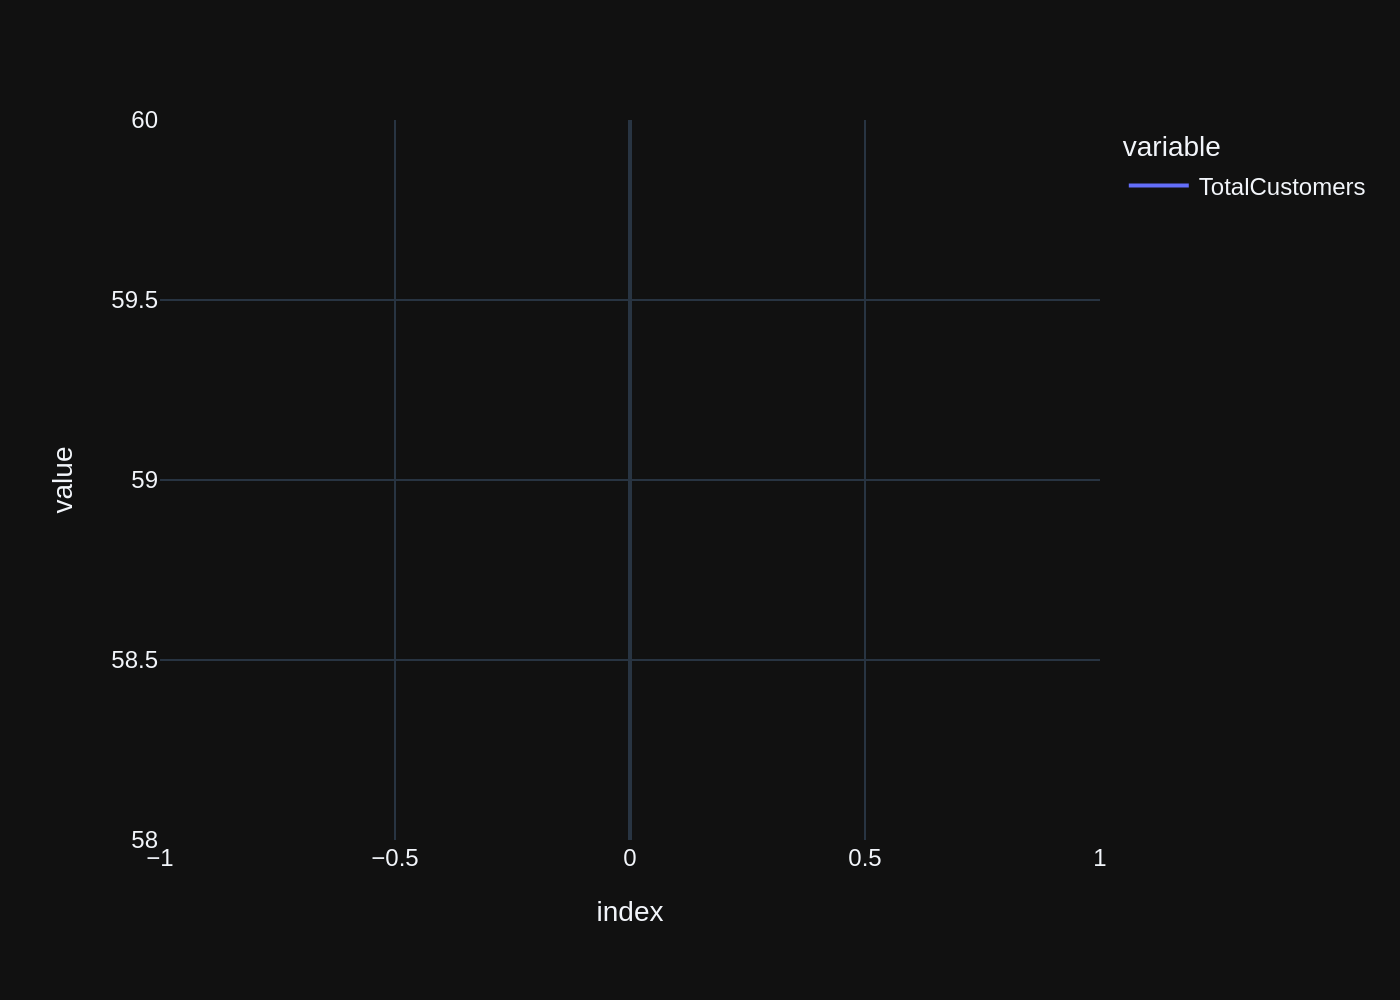

elapsed_time = 2.271334409713745


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model gpt-3.5-turbo for 868.5 tokens (approx)

[( RETRY )]
***** 1 *****

Using model gpt-3.5-turbo for 1001.75 tokens (approx)

[( RETRY )]
***** 2 *****

Using model gpt-3.5-turbo for 1085.75 tokens (approx)

[( RETRY )]
***** 3 *****

Using model gpt-3.5-turbo for 1169.75 tokens (approx)




# QUESTION  - 3:  which table stores customer's orders


Using model gpt-3.5-turbo for 1049.25 tokens (approx)

[( RETRY )]
***** 1 *****

Using model gpt-3.5-turbo for 1032.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name AS "Table storing customer's orders"
FROM sqlite_master
WHERE type='table' AND sql LIKE '%CustomerId%';


[( <SQL> )]
generated SQL statement



SELECT name AS "Table storing customer's orders"
FROM sqlite_master
WHERE type='table' AND sql LIKE '%CustomerId%';


[( <DataFrame> )]
queried dataframe



,Table storing customer's orders
0,customers
1,invoices


Using model gpt-3.5-turbo for 272.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.create_indicator(
        value=df['Table storing customer\'s orders'][0],
        title="Table storing customer's orders"
    )
else:
    fig = px.bar(df, x='Table storing customer\'s orders', title="Table storing customer's orders")

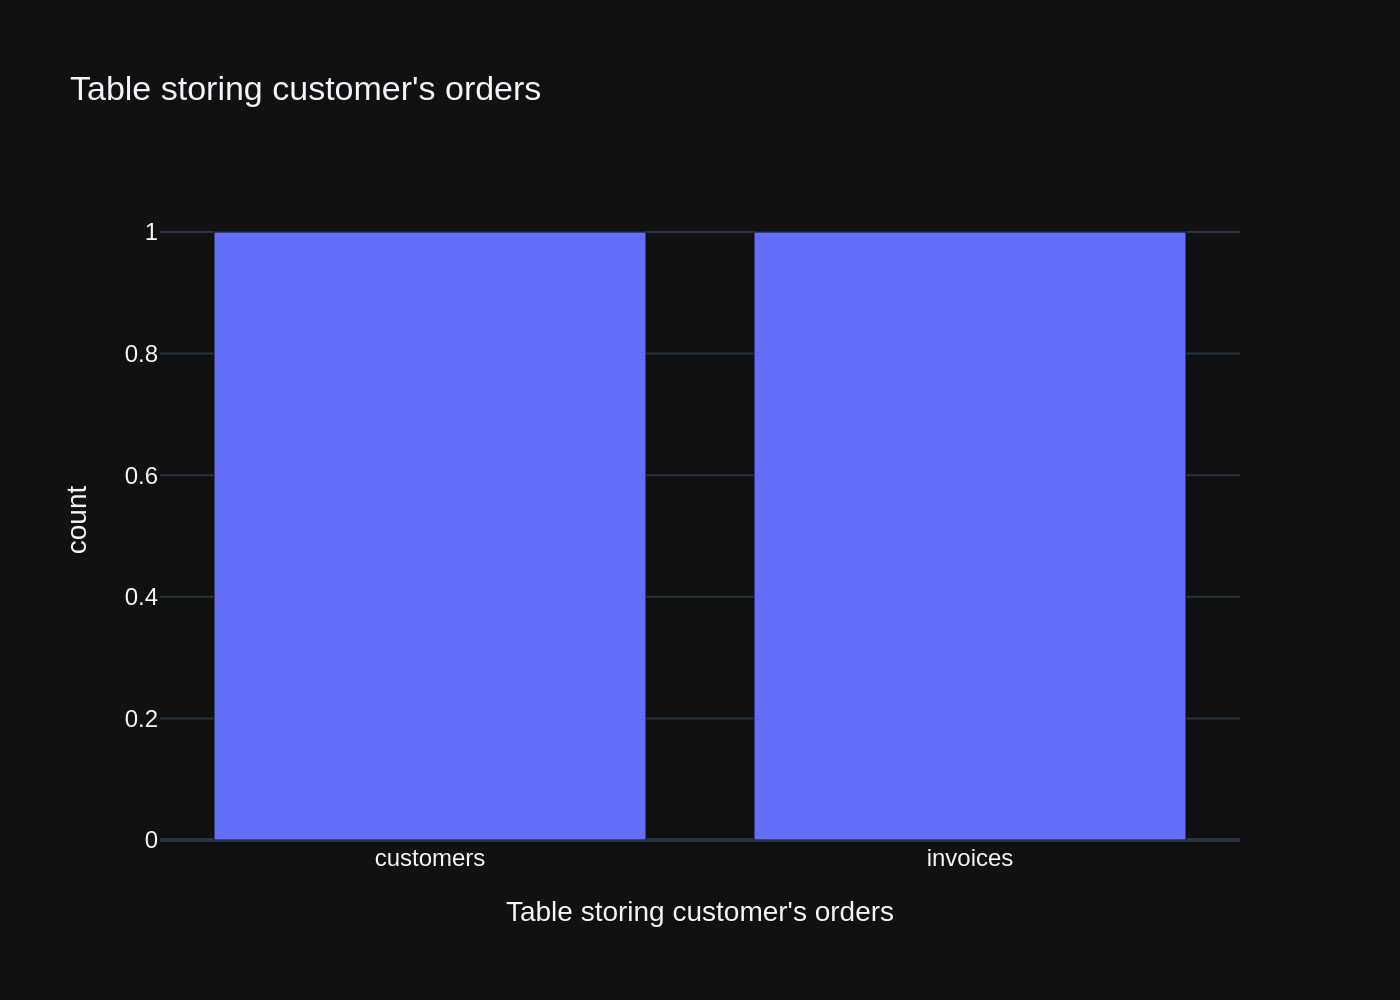





# QUESTION  - 4:  How many customers are there


Using model gpt-3.5-turbo for 1089.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(CustomerId) AS TotalCustomers
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(CustomerId) AS TotalCustomers
FROM customers;


[( <DataFrame> )]
queried dataframe



,TotalCustomers
0,59


Using model gpt-3.5-turbo for 169.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.Indicator(
        mode="number",
        value=df['TotalCustomers'][0]
    )
else:
    fig = px.bar(df, x=df.index, y='TotalCustomers', labels={'x': 'Index', 'TotalCustomers': 'Total Customers'})

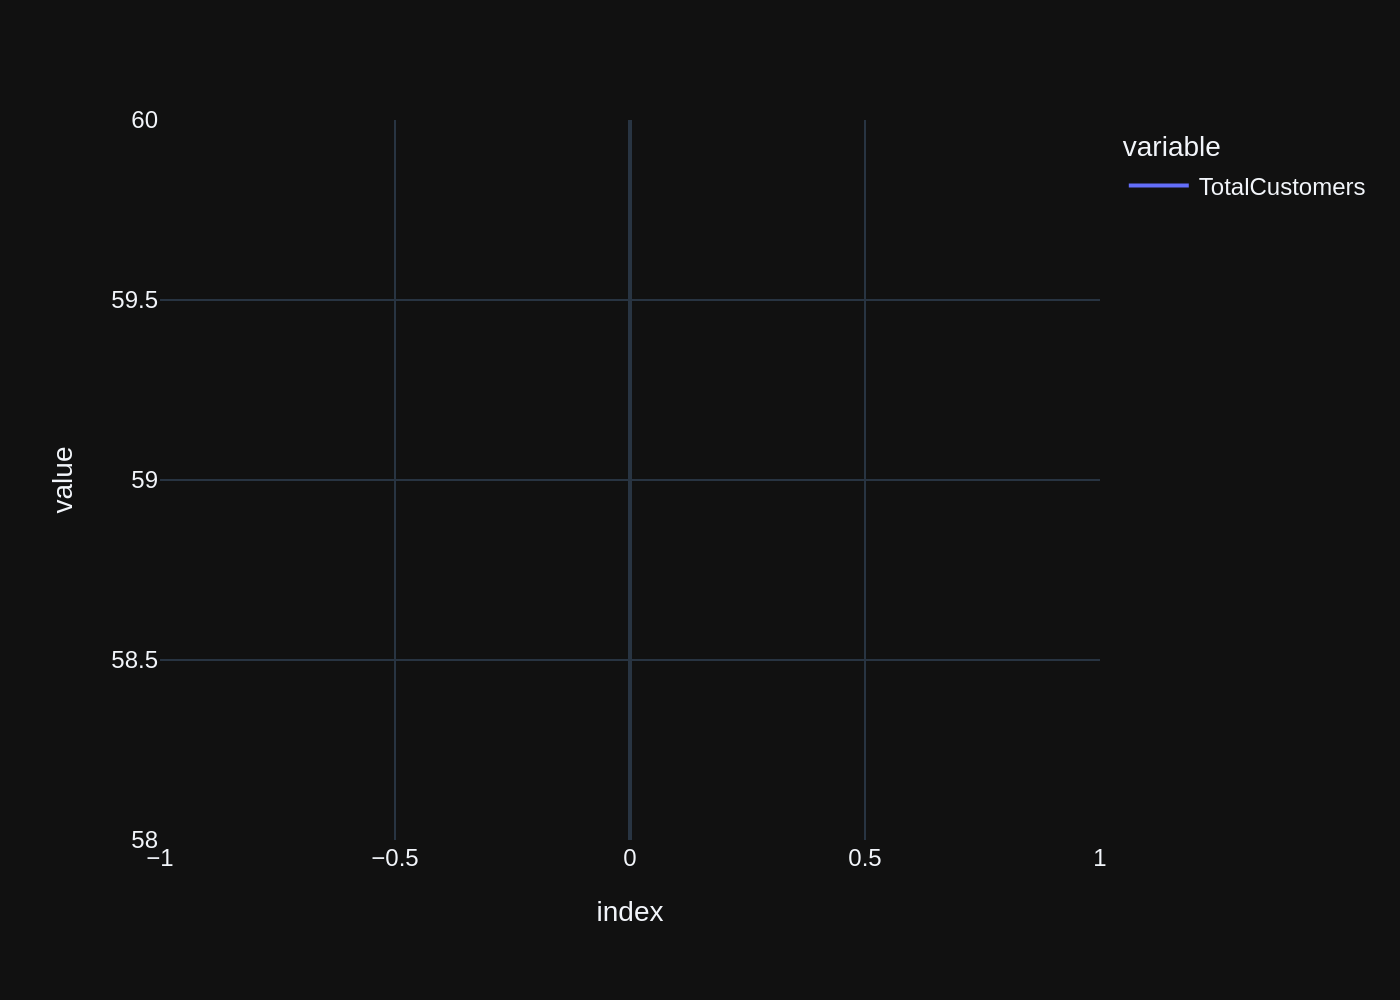





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model gpt-3.5-turbo for 1314.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT Country, COUNT(CustomerId) AS CustomerCount
FROM customers
GROUP BY Country
ORDER BY CustomerCount DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT Country, COUNT(CustomerId) AS CustomerCount
FROM customers
GROUP BY Country
ORDER BY CustomerCount DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,Country,CustomerCount
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4


Using model gpt-3.5-turbo for 195.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.Indicator(
        mode="number",
        value=df['CustomerCount'][0],
        title="Customer Count"
    )
else:
    fig = px.bar(df, x='Country', y='CustomerCount', title='Top 5 Countries by Customer Count')

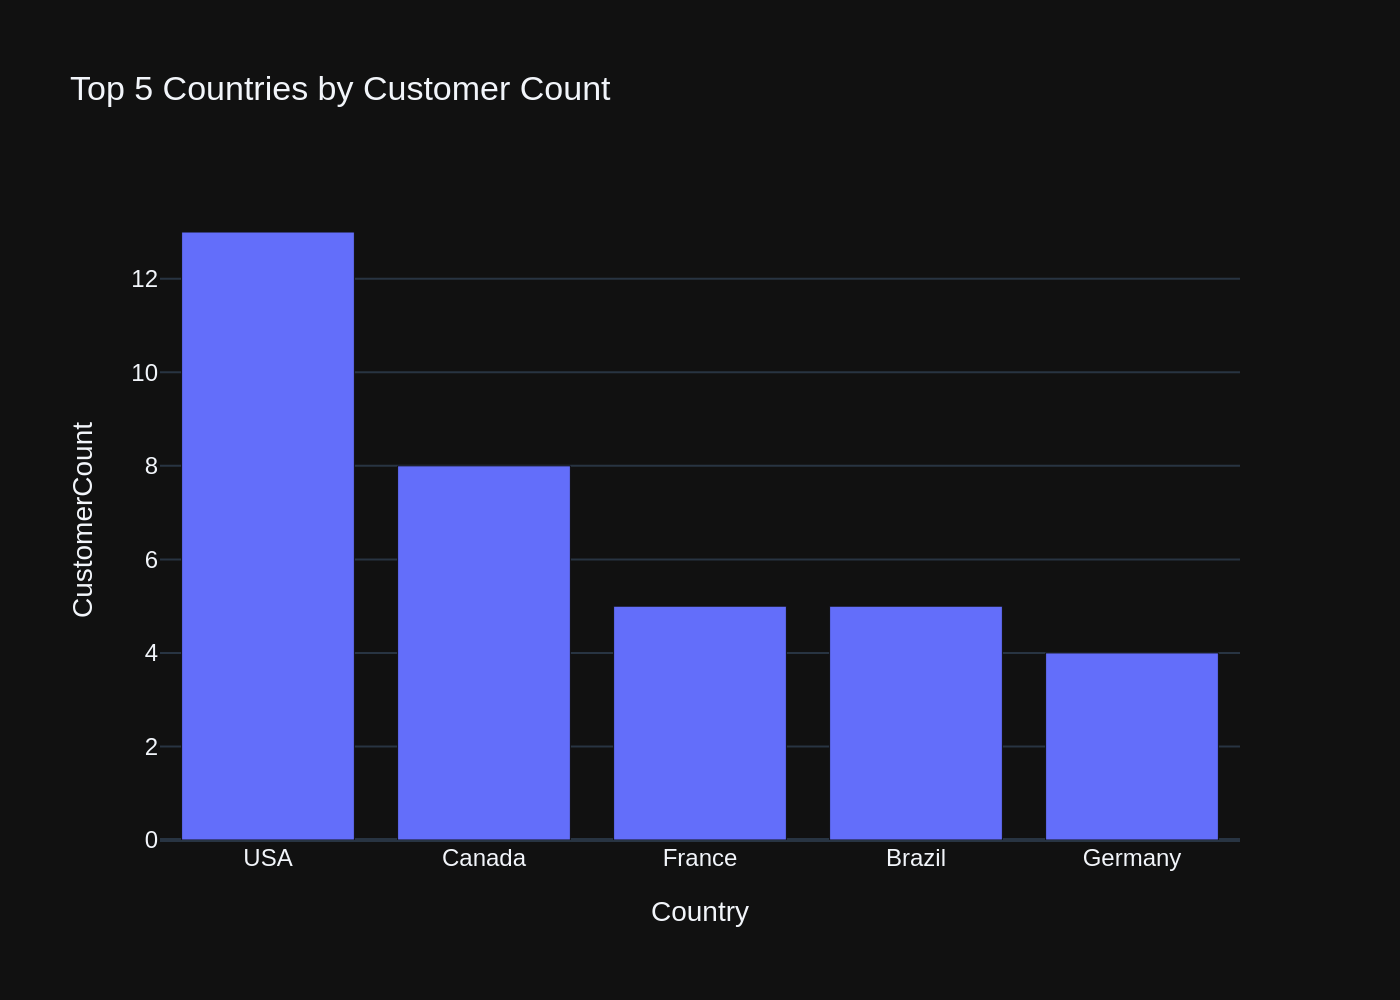





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model gpt-3.5-turbo for 847.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT albums.Title, artists.Name
FROM albums
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <SQL> )]
generated SQL statement



SELECT albums.Title, artists.Name
FROM albums
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <DataFrame> )]
queried dataframe



,Title,Name
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave


Using model gpt-3.5-turbo for 187.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.dataframe(df)
else:
    fig = px.bar(df, x='Title', y='Name', title='Albums and Their Corresponding Artist Names')

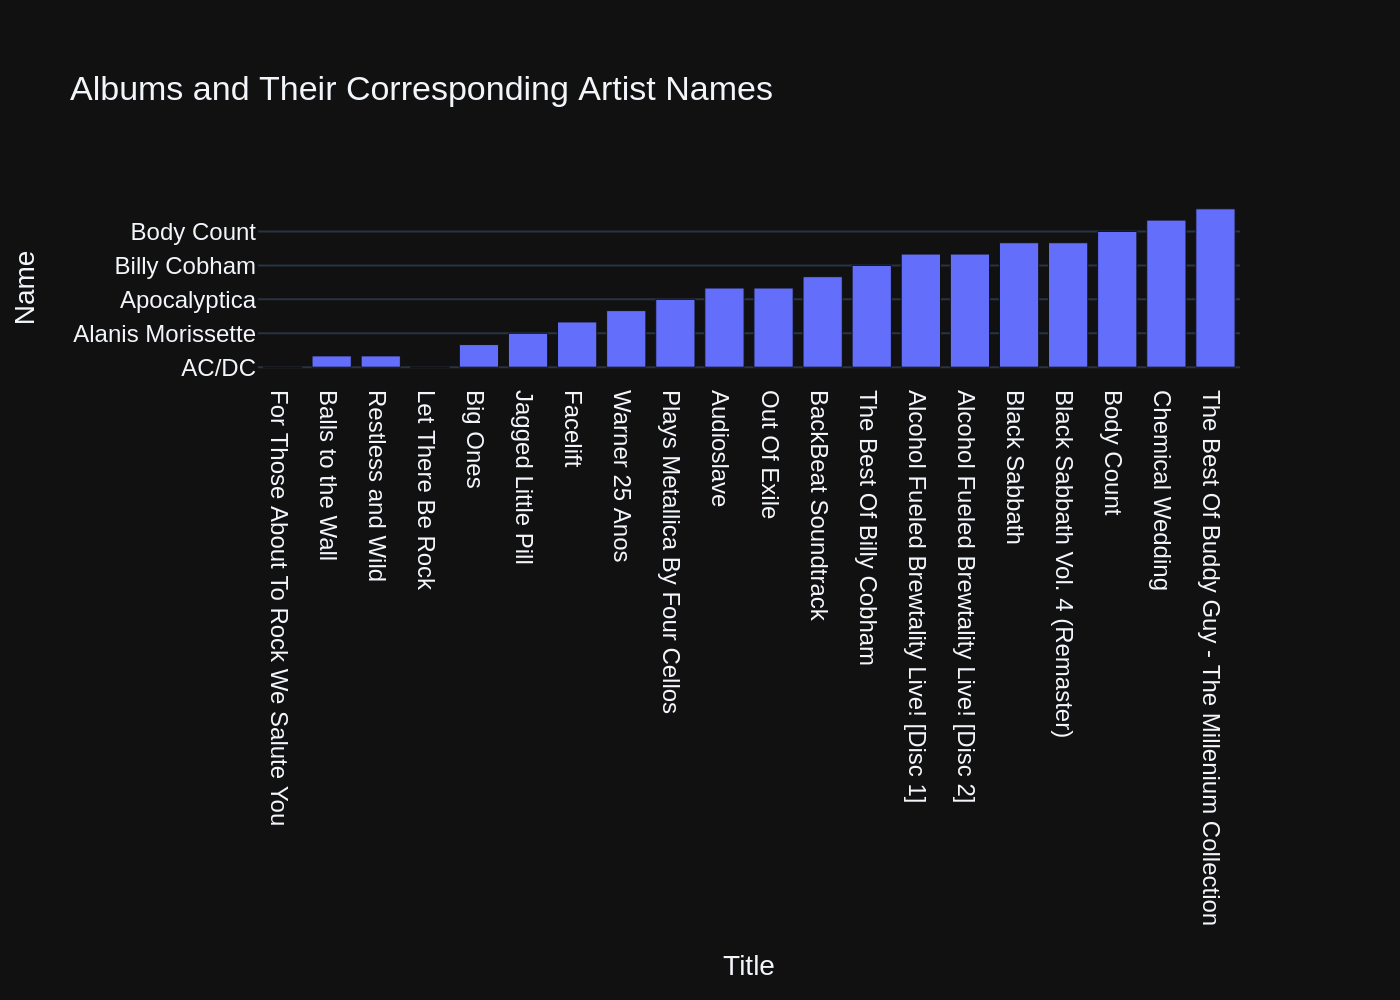





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model gpt-3.5-turbo for 910.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT *
FROM tracks
WHERE Name LIKE '%What%' COLLATE NOCASE;


[( <SQL> )]
generated SQL statement



SELECT *
FROM tracks
WHERE Name LIKE '%What%' COLLATE NOCASE;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99


Using model gpt-3.5-turbo for 227.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(
        value=df['TrackId'][0],
        domain={'x': [0, 1], 'y': [0, 1]}
    )
else:
    fig = px.bar(df, x='Name', y='TrackId', title='Tracks with Name containing "What"')

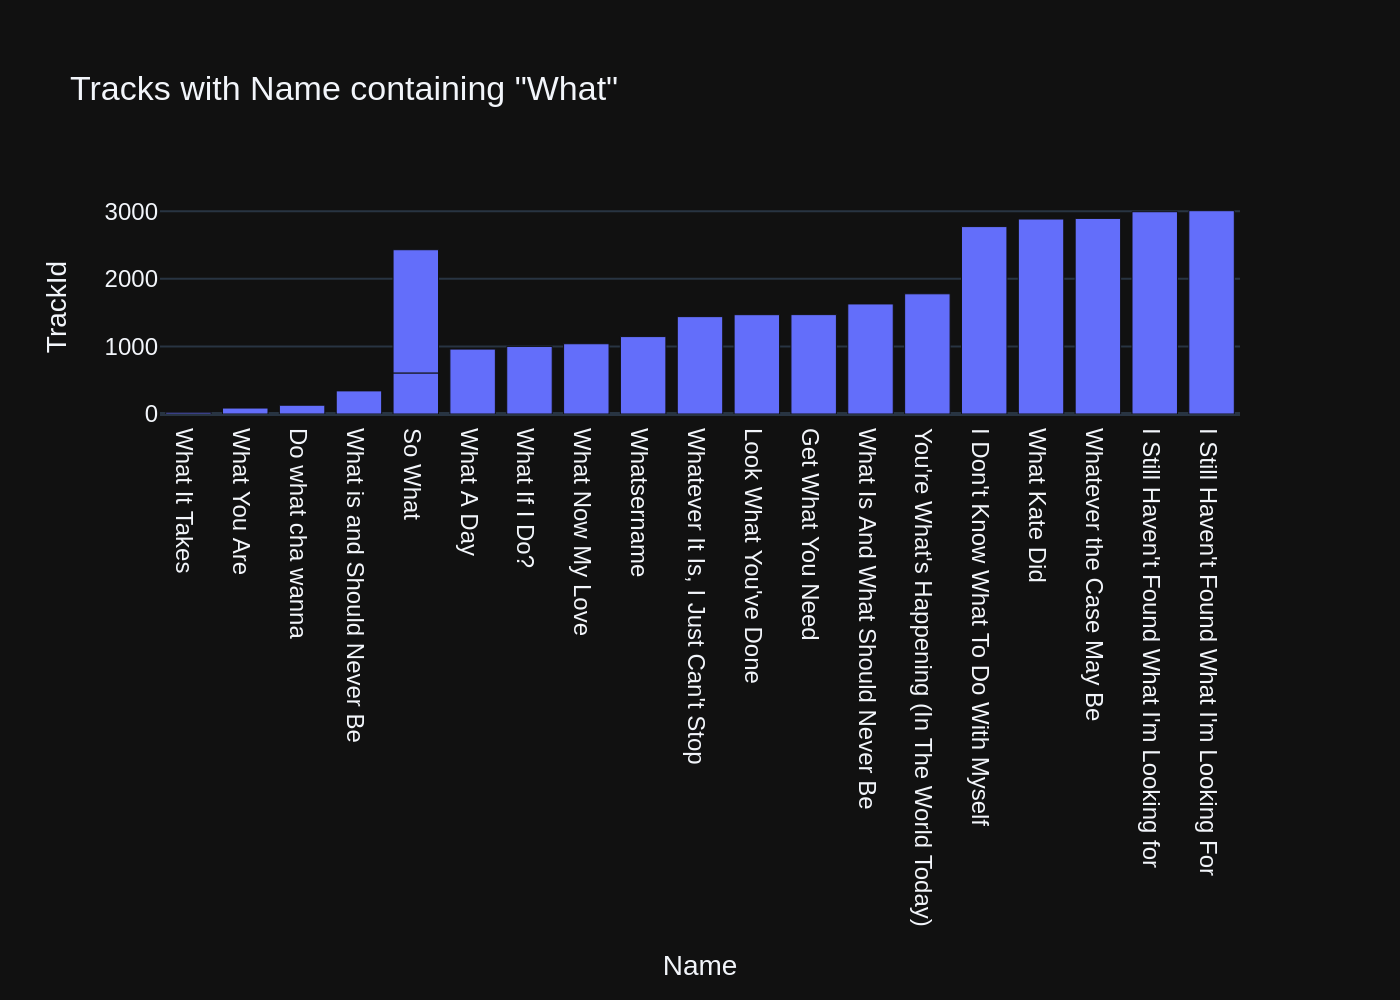





# QUESTION  - 8:  Get the total number of invoices for each customer


Using model gpt-3.5-turbo for 1294.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(InvoiceId) AS TotalInvoices
FROM invoices
GROUP BY CustomerId
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalInvoices
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
5,6,7
6,7,7
7,8,7
8,9,7
9,10,7


Using model gpt-3.5-turbo for 187.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.number(
        value=df['TotalInvoices'][0],
        title="Total Invoices"
    )
else:
    fig = px.bar(df, x='CustomerId', y='TotalInvoices', title='Total Invoices per Customer')

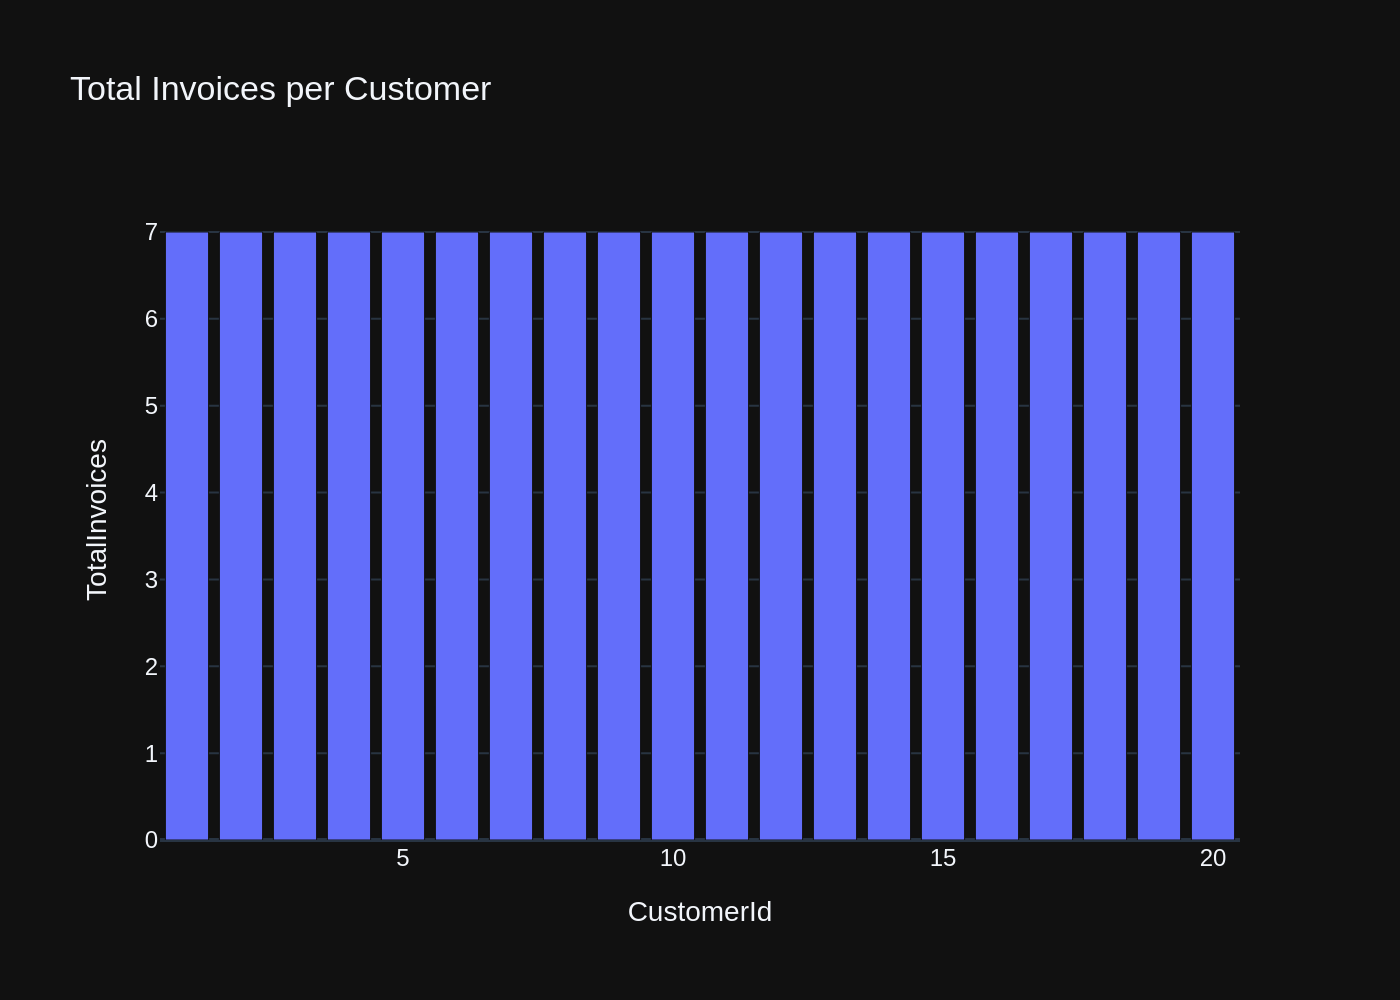





# QUESTION  - 9:  Find the total number of invoices per country


Using model gpt-3.5-turbo for 1377.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT c.Country, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.Country
ORDER BY TotalInvoices DESC;


[( <SQL> )]
generated SQL statement



SELECT c.Country, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.Country
ORDER BY TotalInvoices DESC;


[( <DataFrame> )]
queried dataframe



,Country,TotalInvoices
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28
5,United Kingdom,21
6,Portugal,14
7,Czech Republic,14
8,India,13
9,Sweden,7


Using model gpt-3.5-turbo for 206.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.Indicator(
        value=df['TotalInvoices'][0],
        title="Total Invoices",
        mode="number"
    )
else:
    fig = px.bar(df, x='Country', y='TotalInvoices', title='Total Invoices per Country')

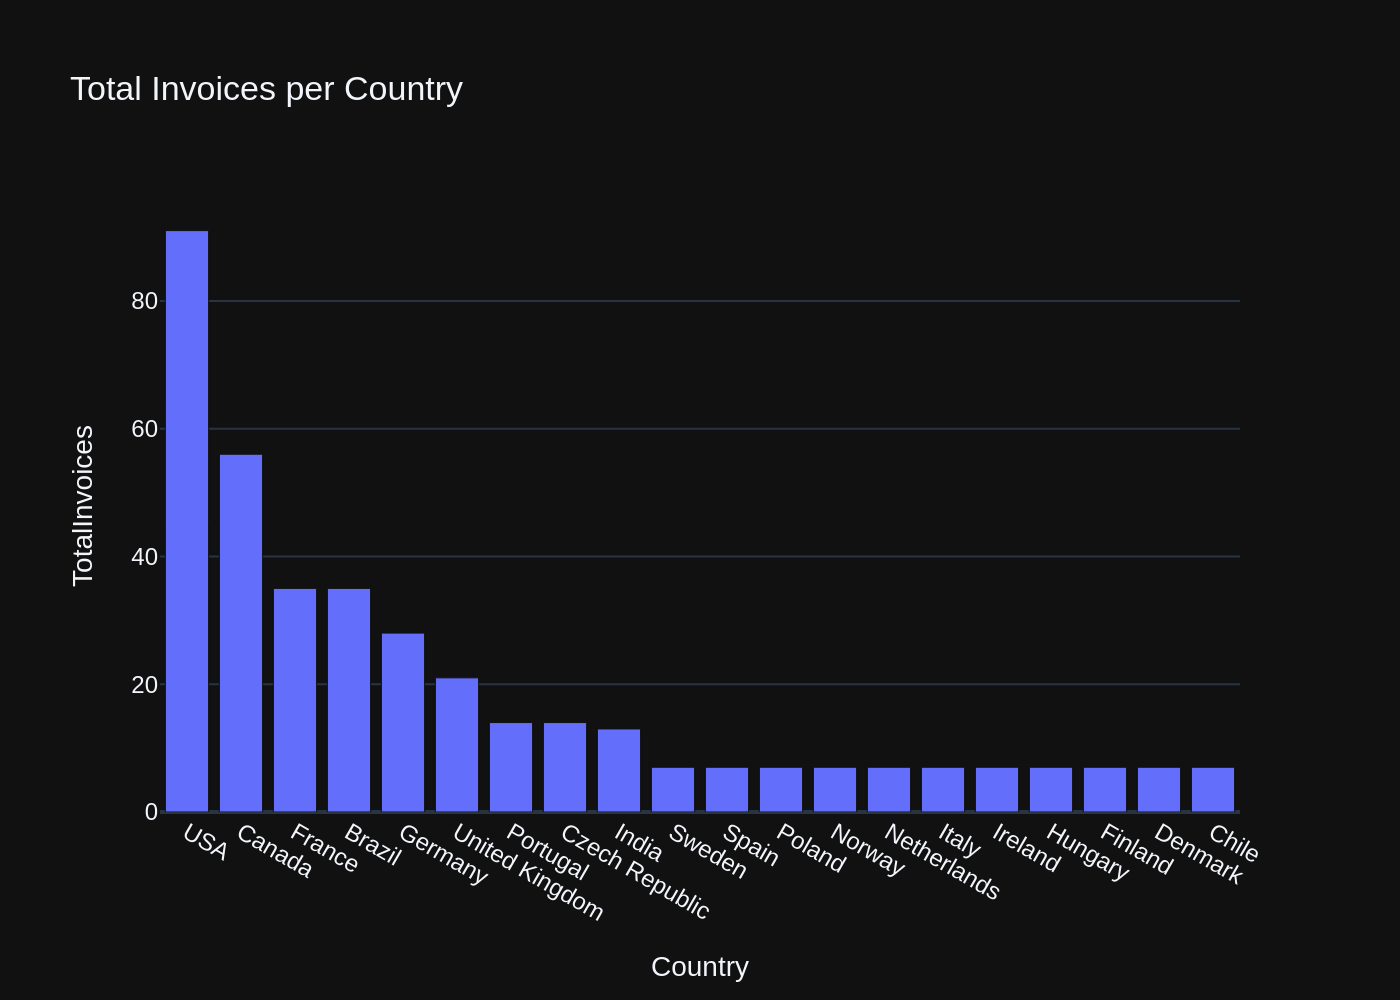





# QUESTION  - 10:  List all invoices with a total exceeding $10


Using model gpt-3.5-turbo for 1384.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT *
FROM invoices
WHERE Total > 10.00
LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
5,40,36,2009-06-15 00:00:00,Tauentzienstraße 8,Berlin,None,Germany,10789,13.86
6,47,15,2009-07-16 00:00:00,700 W Pender Street,Vancouver,BC,Canada,V6C 1G8,13.86
7,54,53,2009-08-16 00:00:00,113 Lupus St,London,None,United Kingdom,SW1V 3EN,13.86
8,61,32,2009-09-16 00:00:00,696 Osborne Street,Winnipeg,MB,Canada,R3L 2B9,13.86
9,68,11,2009-10-17 00:00:00,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,13.86


Using model gpt-3.5-turbo for 229.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.number(
        value=df['Total'][0],
        title="Total"
    )
else:
    fig = px.bar(df, x='InvoiceId', y='Total', title='Invoices with Total > $10')

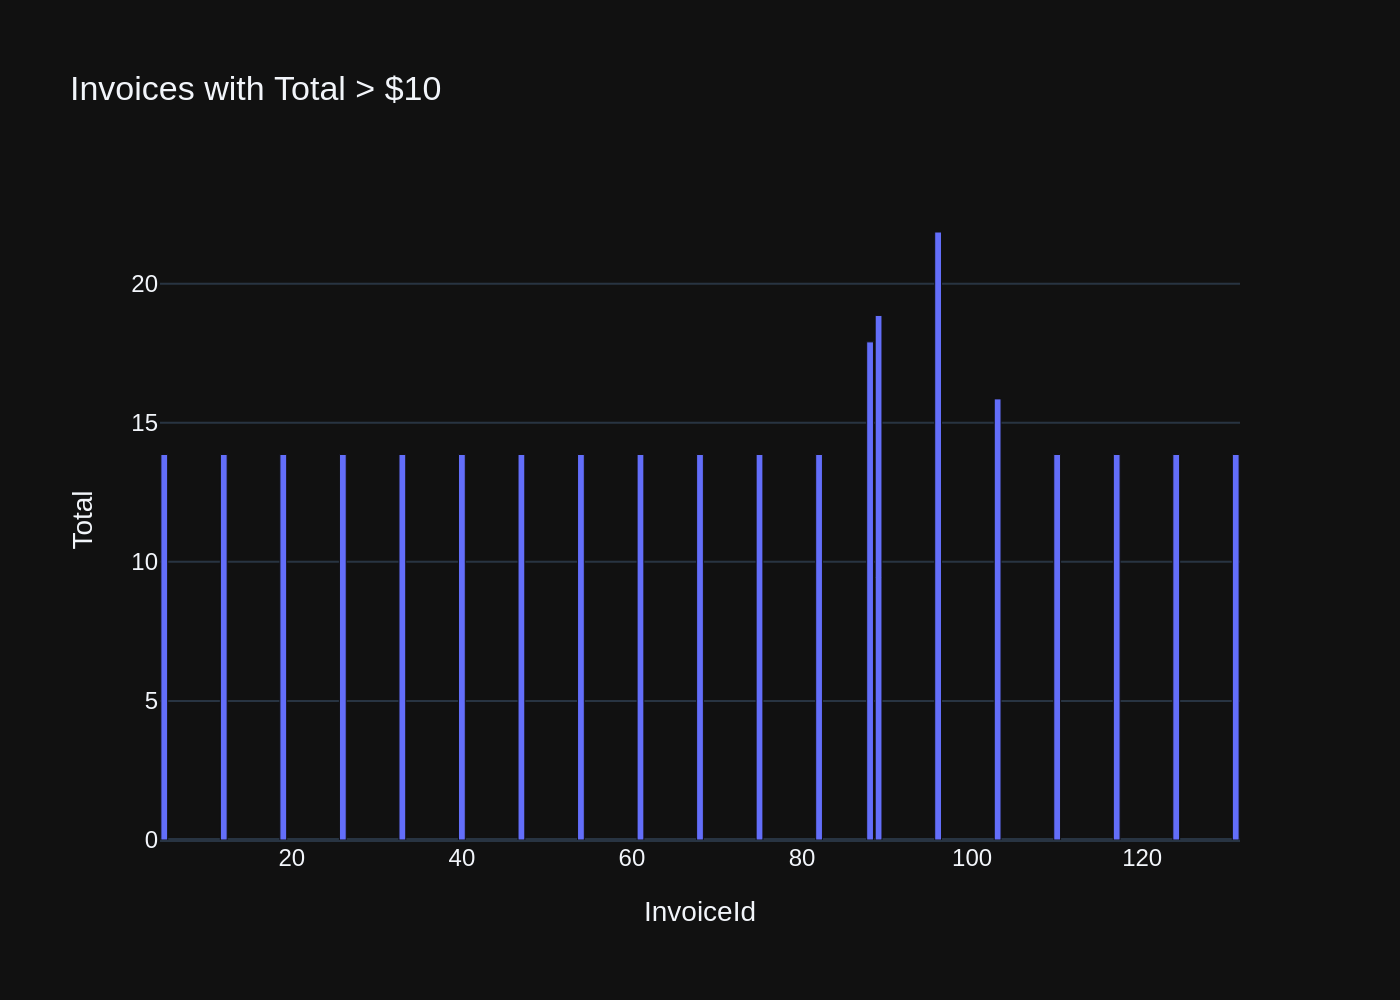





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:


Using model gpt-3.5-turbo for 1539.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT InvoiceDate, Total
FROM invoices
WHERE InvoiceDate >= '2010-01-01'
ORDER BY InvoiceDate

SELECT SUM(Total) AS TotalAmountInvoiced
FROM invoices
WHERE InvoiceDate >= '2010-01-01'


[( RETRY )]
***** 1 *****

Using model gpt-3.5-turbo for 1346.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT SUM(Total) AS TotalAmountInvoiced
FROM invoices
WHERE InvoiceDate >= '2010-01-01';


[( <SQL> )]
generated SQL statement



SELECT SUM(Total) AS TotalAmountInvoiced
FROM invoices
WHERE InvoiceDate >= '2010-01-01';


[( <DataFrame> )]
queried dataframe



,TotalAmountInvoiced
0,1879.14


Using model gpt-3.5-turbo for 358.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(value=df['TotalAmountInvoiced'][0], title='Total Amount Invoiced')
else:
    fig = px.bar(df, x=df.index, y='TotalAmountInvoiced', title='Total Amount Invoiced Over Time')

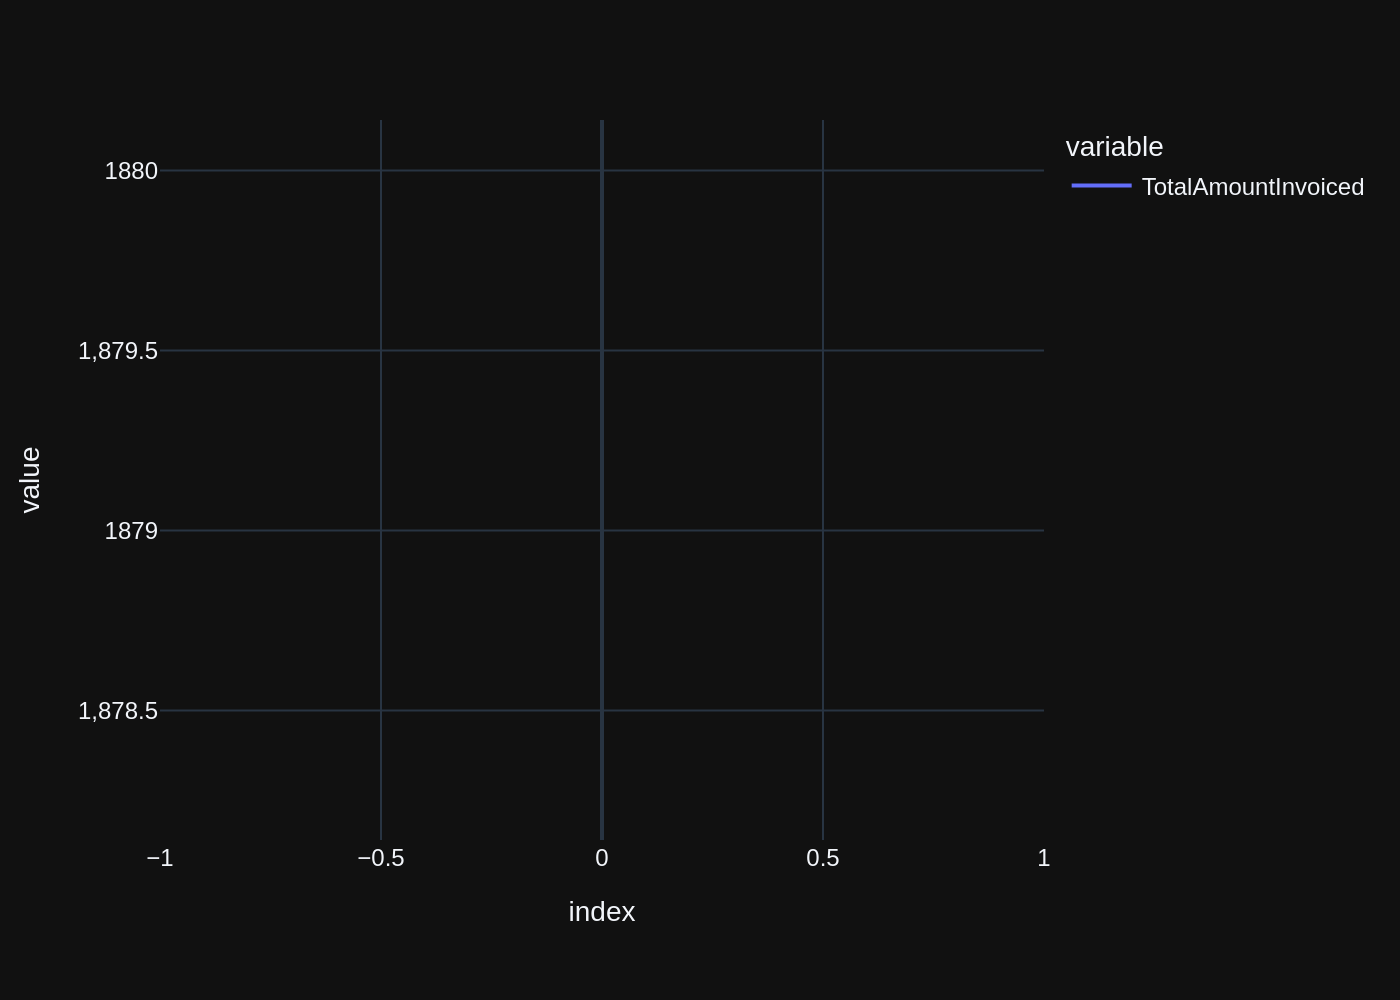





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):


Using model gpt-3.5-turbo for 1676.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, 
       m.FirstName || ' ' || m.LastName AS ManagerName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId
ORDER BY EmployeeName;


[( <SQL> )]
generated SQL statement



SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, 
       m.FirstName || ' ' || m.LastName AS ManagerName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId
ORDER BY EmployeeName;


[( <DataFrame> )]
queried dataframe



,EmployeeName,ManagerName
0,Andrew Adams,None
1,Jane Peacock,Nancy Edwards
2,Laura Callahan,Michael Mitchell
3,Margaret Park,Nancy Edwards
4,Michael Mitchell,Andrew Adams
5,Nancy Edwards,Andrew Adams
6,Robert King,Michael Mitchell
7,Steve Johnson,Nancy Edwards


Using model gpt-3.5-turbo for 220.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.create_indicator(
        value=df['EmployeeName'][0],
        title='Employee Name'
    )
else:
    fig = px.bar(df, x='EmployeeName', y='ManagerName', title='Employees and Their Reporting Managers')

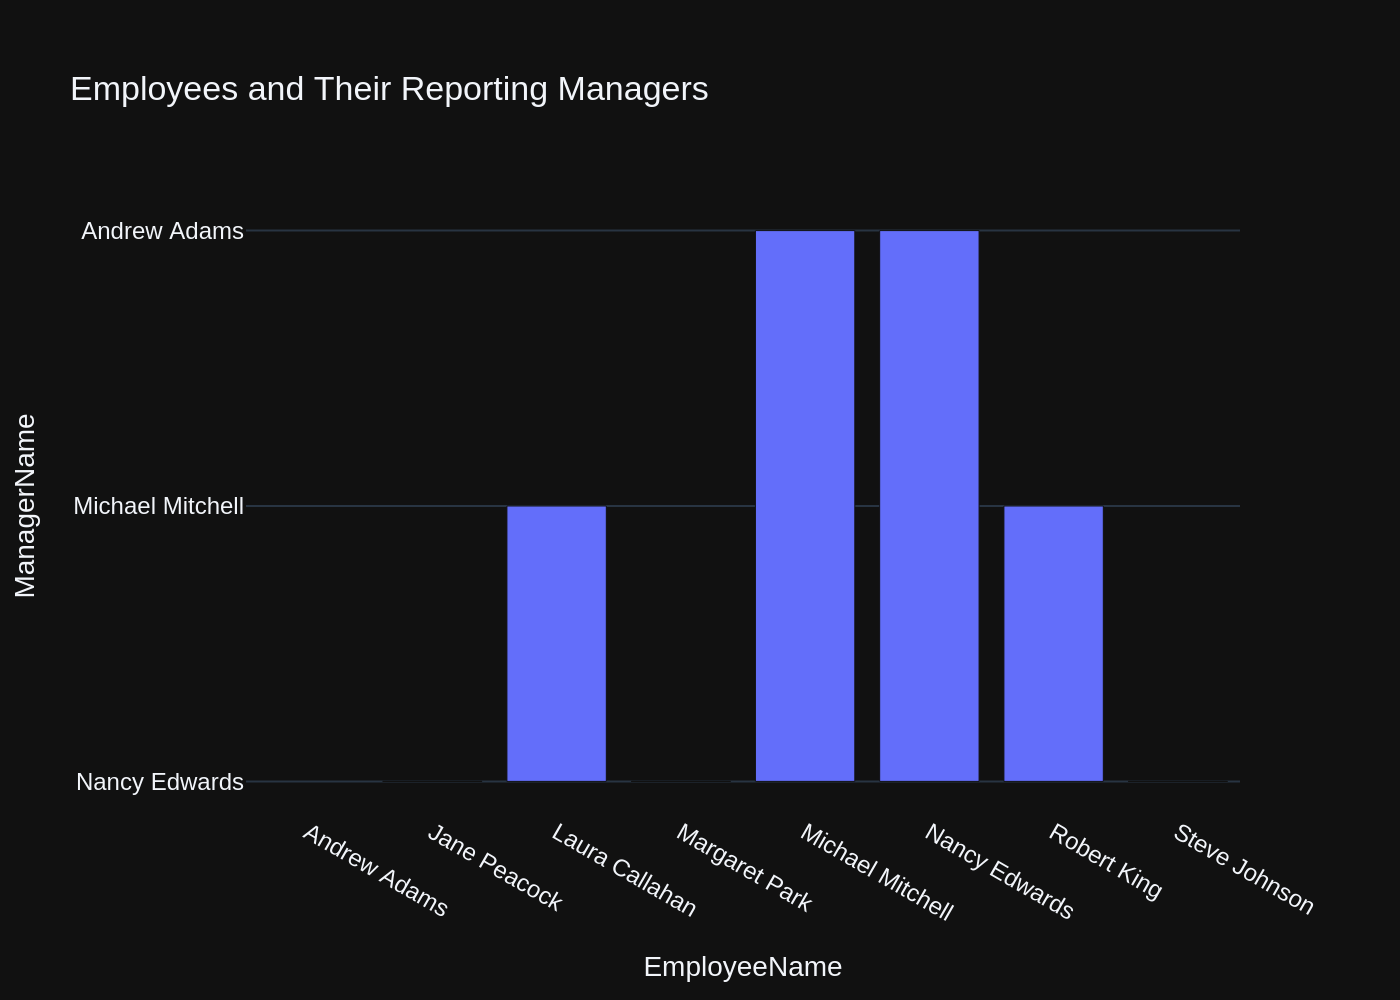





# QUESTION  - 13:   Get the average invoice total for each customer:


Using model gpt-3.5-turbo for 1537.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, AVG(Total) AS AvgInvoiceTotal
FROM invoices
GROUP BY CustomerId
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,AvgInvoiceTotal
0,1,5.660000
1,2,5.374286
2,3,5.660000
3,4,5.660000
4,5,5.802857
5,6,7.088571
6,7,6.088571
7,8,5.374286
8,9,5.374286
9,10,5.374286


Using model gpt-3.5-turbo for 188.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.number(
        value=df['AvgInvoiceTotal'][0],
        title="Average Invoice Total"
    )
else:
    fig = px.bar(df, x='CustomerId', y='AvgInvoiceTotal', title='Average Invoice Total per Customer')

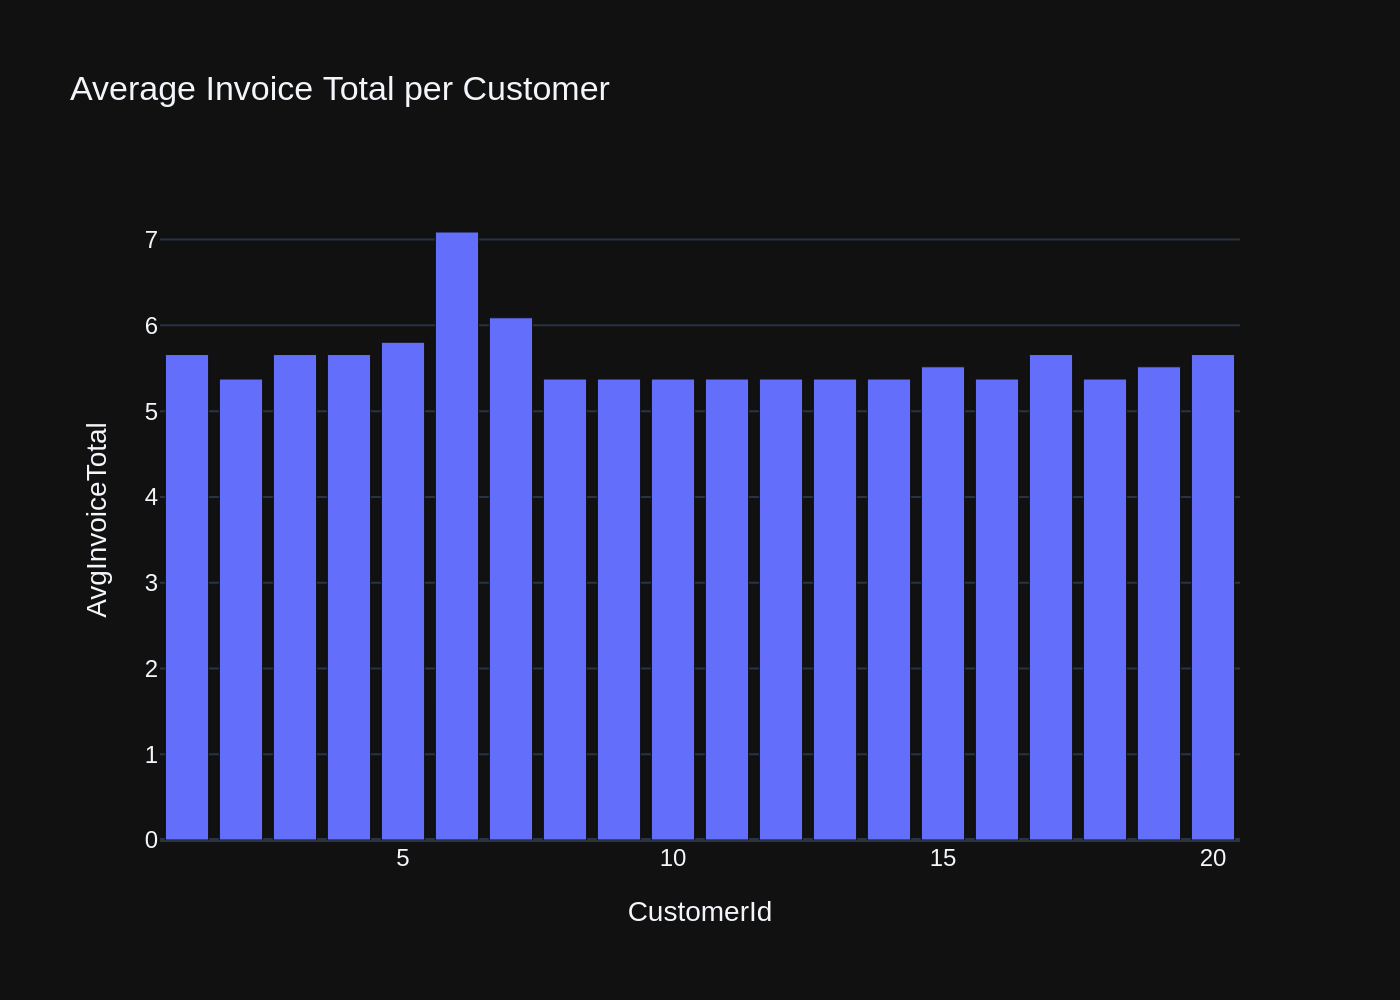





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):


Using model gpt-3.5-turbo for 1370.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT Name, UnitPrice
FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,Name,UnitPrice
0,Battlestar Galactica: The Story So Far,1.99
1,Occupation / Precipice,1.99
2,"Exodus, Pt. 1",1.99
3,"Exodus, Pt. 2",1.99
4,Collaborators,1.99


Using model gpt-3.5-turbo for 181.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(value=df['UnitPrice'][0], domain={'x': [0, 1], 'y': [0, 1]})
else:
    fig = px.bar(df, x='Name', y='UnitPrice', title='Top 5 Most Expensive Tracks', labels={'UnitPrice': 'Unit Price'})

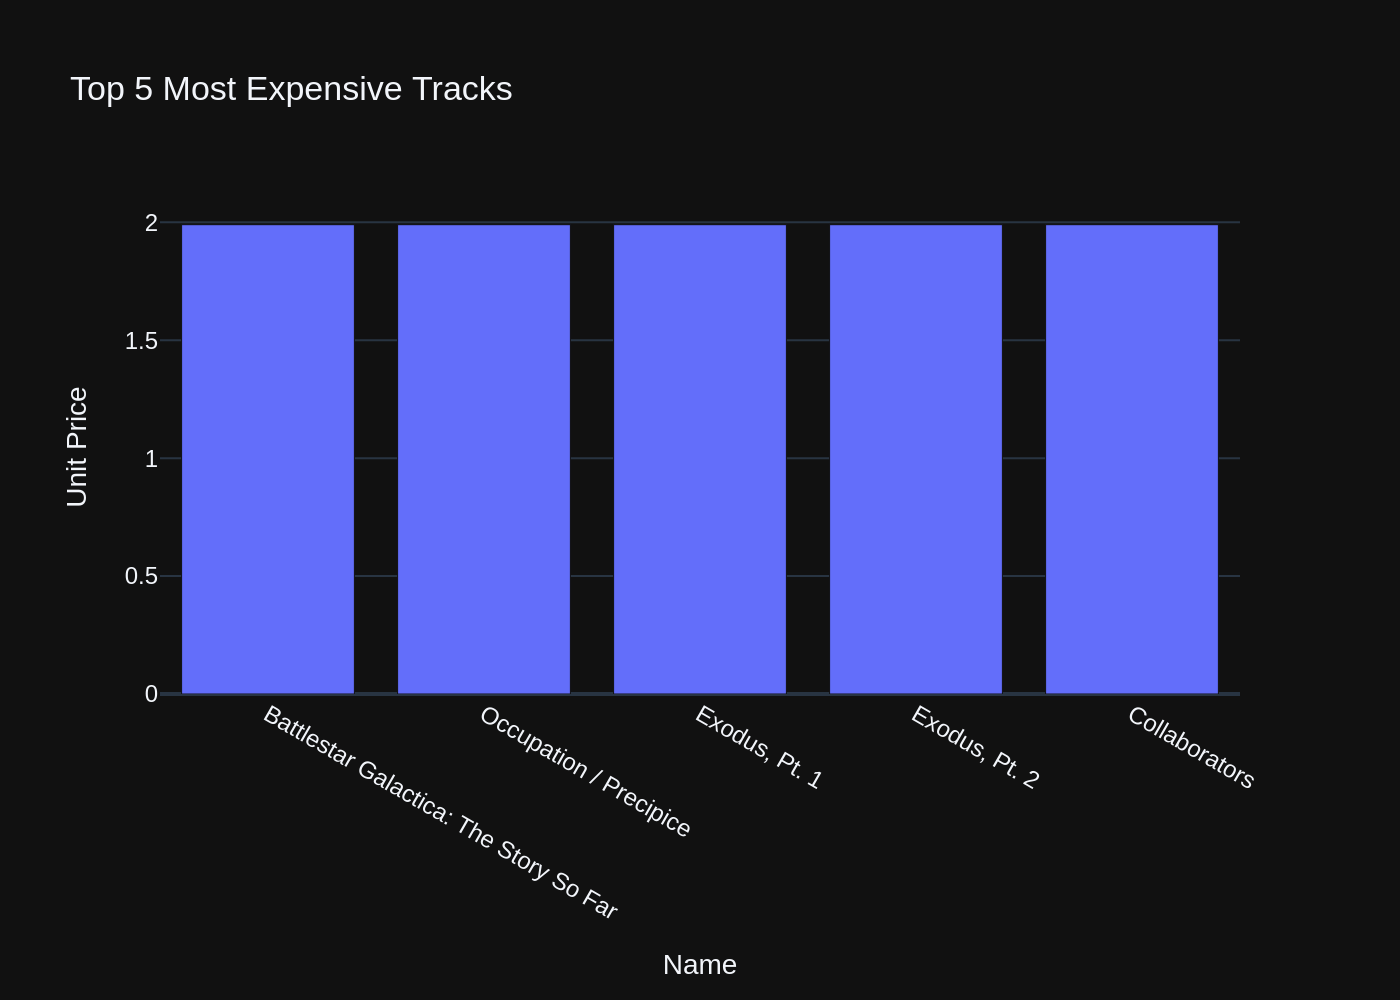





# QUESTION  - 15:  List all genres and the number of tracks in each genre:


Using model gpt-3.5-turbo for 1117.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT g.Name AS Genre, COUNT(t.TrackId) AS TrackCount
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
ORDER BY TrackCount DESC;


[( <SQL> )]
generated SQL statement



SELECT g.Name AS Genre, COUNT(t.TrackId) AS TrackCount
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
ORDER BY TrackCount DESC;


[( <DataFrame> )]
queried dataframe



,Genre,TrackCount
0,Rock,1297
1,Latin,579
2,Metal,374
3,Alternative & Punk,332
4,Jazz,130
5,TV Shows,93
6,Blues,81
7,Classical,74
8,Drama,64
9,R&B/Soul,61


Using model gpt-3.5-turbo for 205.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(
        value=df['TrackCount'][0],
        title='Track Count',
        mode='number'
    )
else:
    fig = px.bar(df, x='Genre', y='TrackCount', title='Number of Tracks in Each Genre')

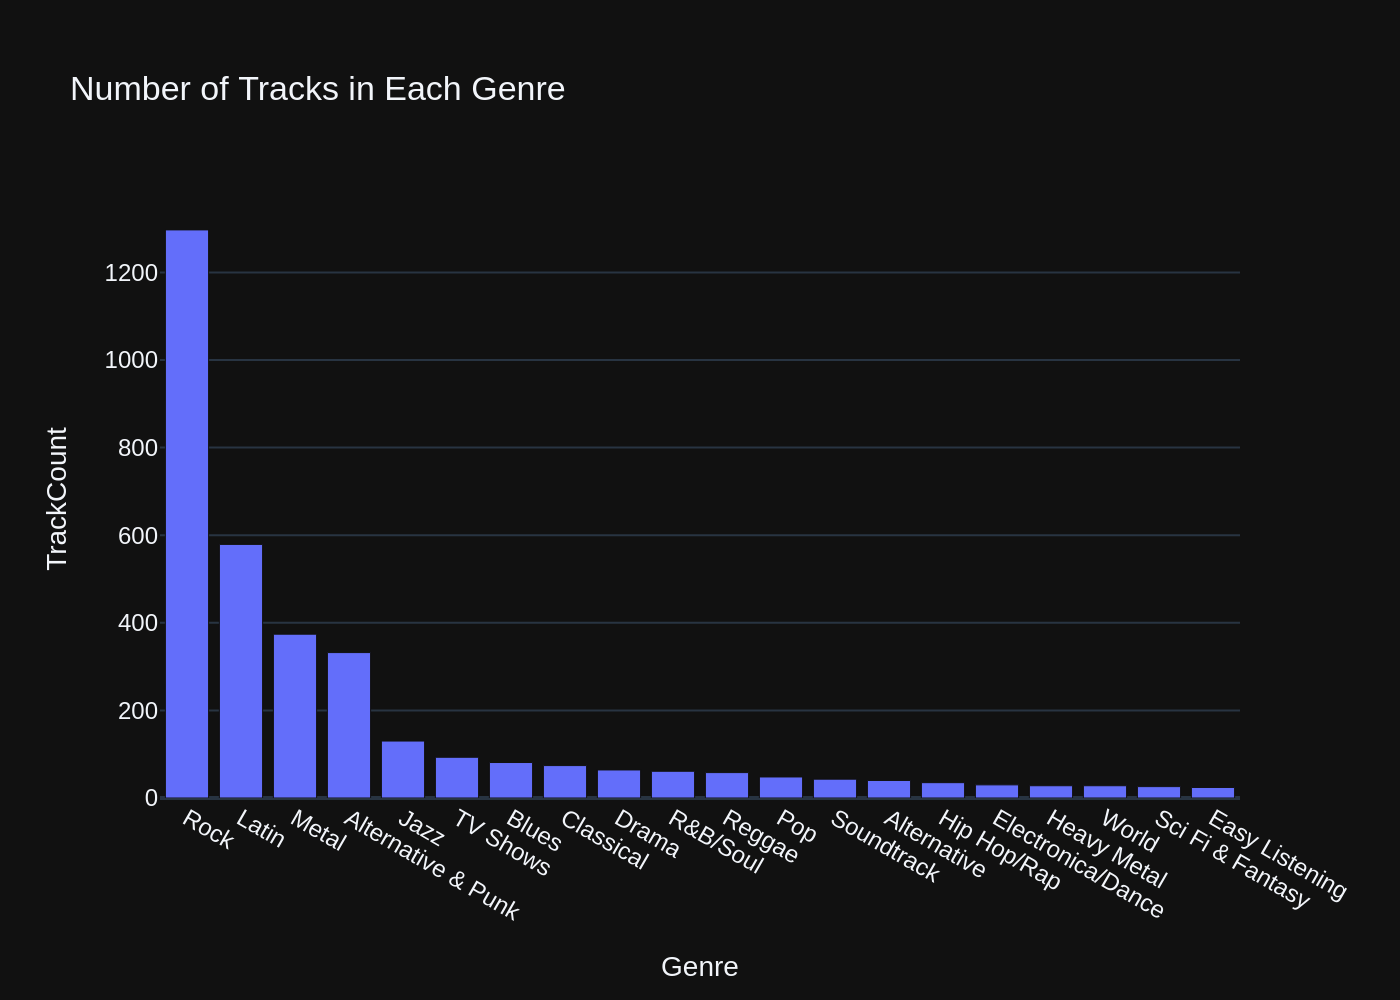





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:


Using model gpt-3.5-turbo for 1236.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.GenreId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Genre



[( RETRY )]
***** 1 *****

Using model gpt-3.5-turbo for 1503.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.GenreId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Genre



[( RETRY )]
***** 2 *****

Using model gpt-3.5-turbo for 1550.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT g.Name AS Genre, COUNT(t.TrackId) AS TrackCount
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
HAVING TrackCount = 0;

Using model gpt-3.5-turbo for 1624.25 tokens (approx)

[( EXTRACTED SQL )]
with them:

```sql
SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.GenreId IS NULL;


[( <SQL> )]
generated SQL statement



with them:

```sql
SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.GenreId IS NULL;


[( RETRY )]
***** 3 *****

Using model gpt-3.5-turbo for 1610.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.GenreId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.GenreId IS NULL;


[( <DataFrame> )]
queried dataframe



,Genre






# QUESTION  - 17:  List all customers who have not placed any orders:


Using model gpt-3.5-turbo for 1830.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName



[( RETRY )]
***** 1 *****

Using model gpt-3.5-turbo for 1710.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT *
FROM customers
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices)
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 2 *****

Using model gpt-3.5-turbo for 1755.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT *
FROM customers
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices) LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 3 *****

Using model gpt-3.5-turbo for 1810.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT *
FROM customers
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices)
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


Using model gpt-3.5-turbo for 1199.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT ar.Name AS ArtistName, COUNT(t.TrackId) AS TrackCount
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId
ORDER BY TrackCount DESC
LIMIT 10;


[( <SQL> )]
generated SQL statement



SELECT ar.Name AS ArtistName, COUNT(t.TrackId) AS TrackCount
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId
ORDER BY TrackCount DESC
LIMIT 10;


[( <DataFrame> )]
queried dataframe



,ArtistName,TrackCount
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


Using model gpt-3.5-turbo for 267.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(
        value=df['TrackCount'][0],
        title='Track Count',
        mode='number'
    )
else:
    fig = px.bar(df, x='ArtistName', y='TrackCount', title='Top 10 Most Popular Artists Based on Number of Tracks')

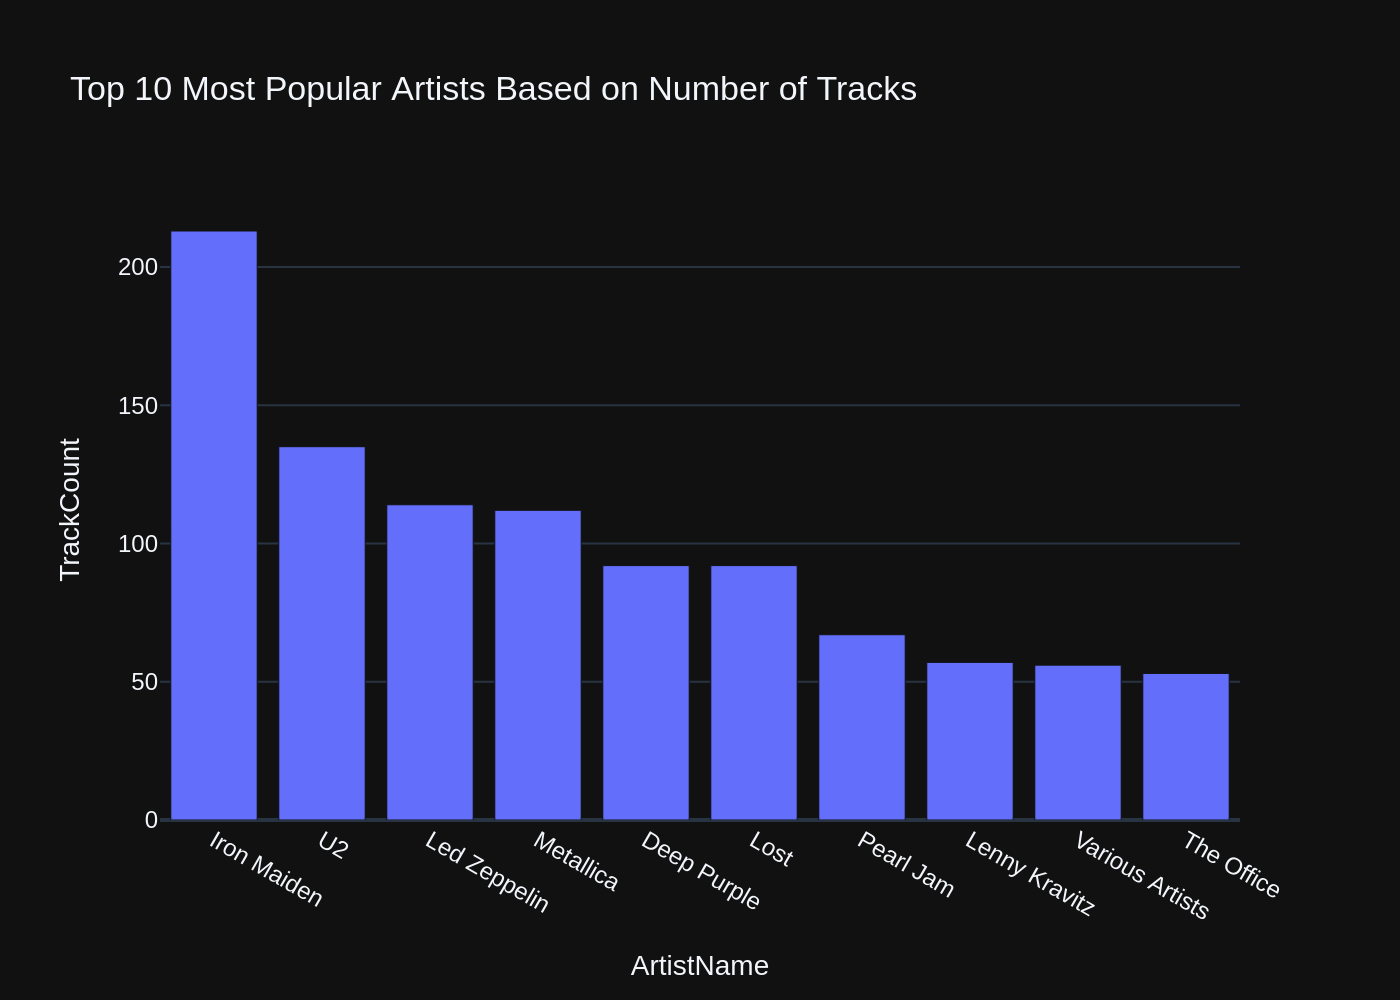





# QUESTION  - 19:  List all customers from Canada and their email addresses:


Using model gpt-3.5-turbo for 1488.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada' LIMIT 20


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca


Using model gpt-3.5-turbo for 189.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.create_indicator(
        value=df['Email'][0],
        title="Email Address"
    )
else:
    fig = px.bar(df, x='FirstName', y='Email', text='Email', title='Customers from Canada and their Email Addresses')

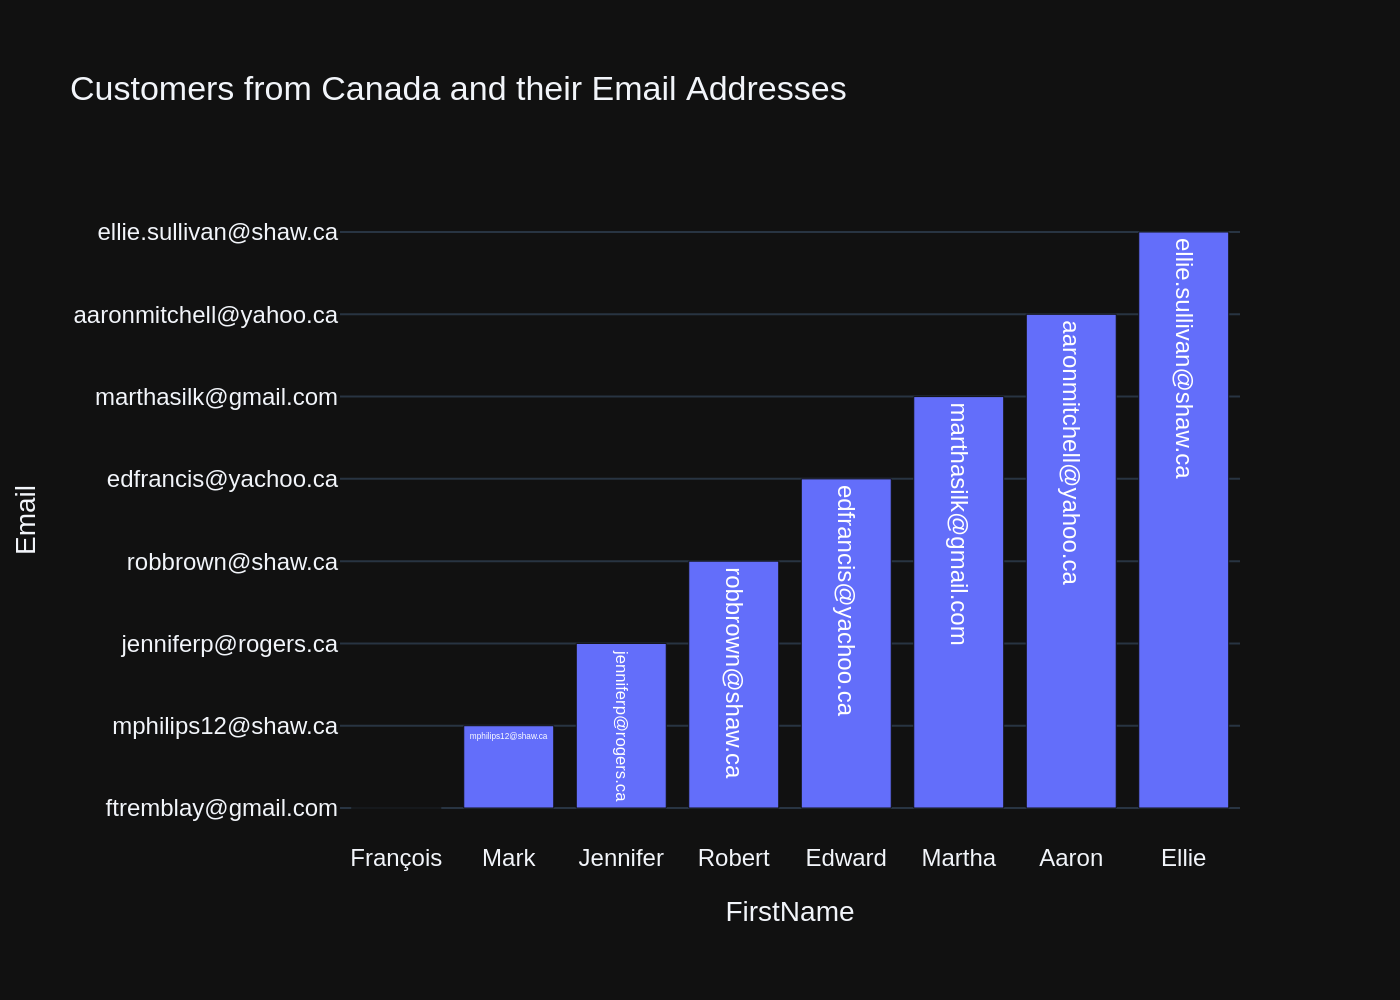





# QUESTION  - 20:  Find the customer with the most invoices 


Using model gpt-3.5-turbo for 1593.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalInvoices DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalInvoices
0,1,Luís,Gonçalves,7


Using model gpt-3.5-turbo for 231.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.number(
        value=df['TotalInvoices'][0],
        title="Total Invoices",
        mode="number+delta",
        delta={'reference': 0}
    )
else:
    fig = px.bar(df, x='FirstName', y='TotalInvoices', title='Total Invoices per Customer', text='TotalInvoices')

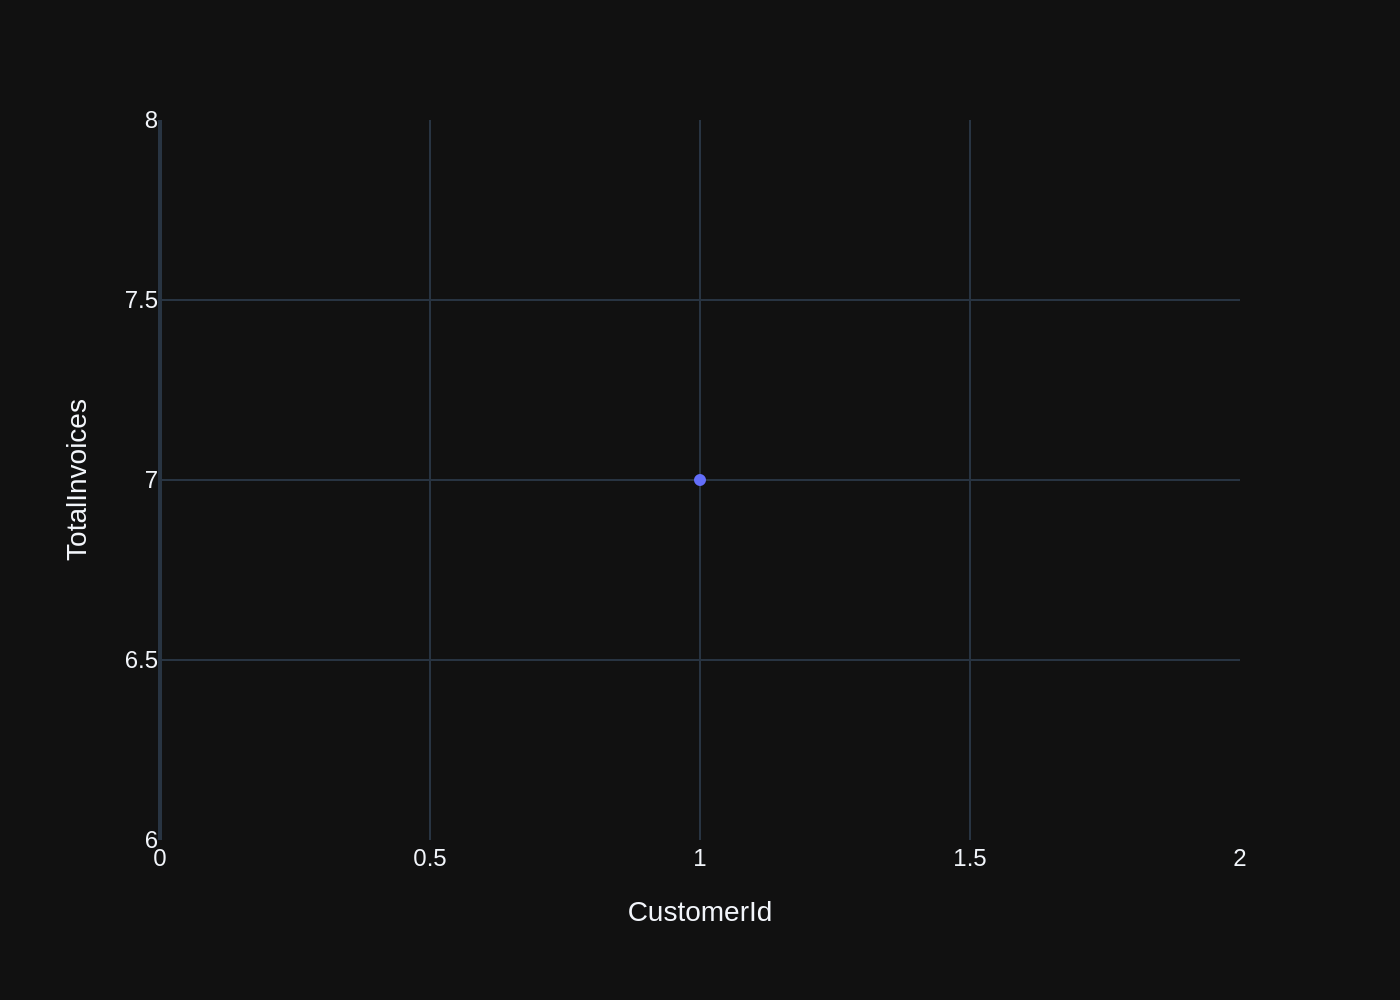





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


Using model gpt-3.5-turbo for 1328.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS TotalAlbumsBought
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
WHERE t.AlbumId IS NOT NULL
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalAlbumsBought DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalAlbumsBought
0,1,Luís,Gonçalves,38


Using model gpt-3.5-turbo for 277.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(
        value=df['TotalAlbumsBought'][0],
        title={'text': 'Total Albums Bought'},
        mode="number",
        domain={'x': [0, 1], 'y': [0, 1]}
    )
else:
    fig = px.bar(df, x='LastName', y='TotalAlbumsBought', text='TotalAlbumsBought', title='Total Albums Bought per Customer', labels={'TotalAlbumsBought': 'Total Albums Bought', 'LastName': 'Customer Last Name'})

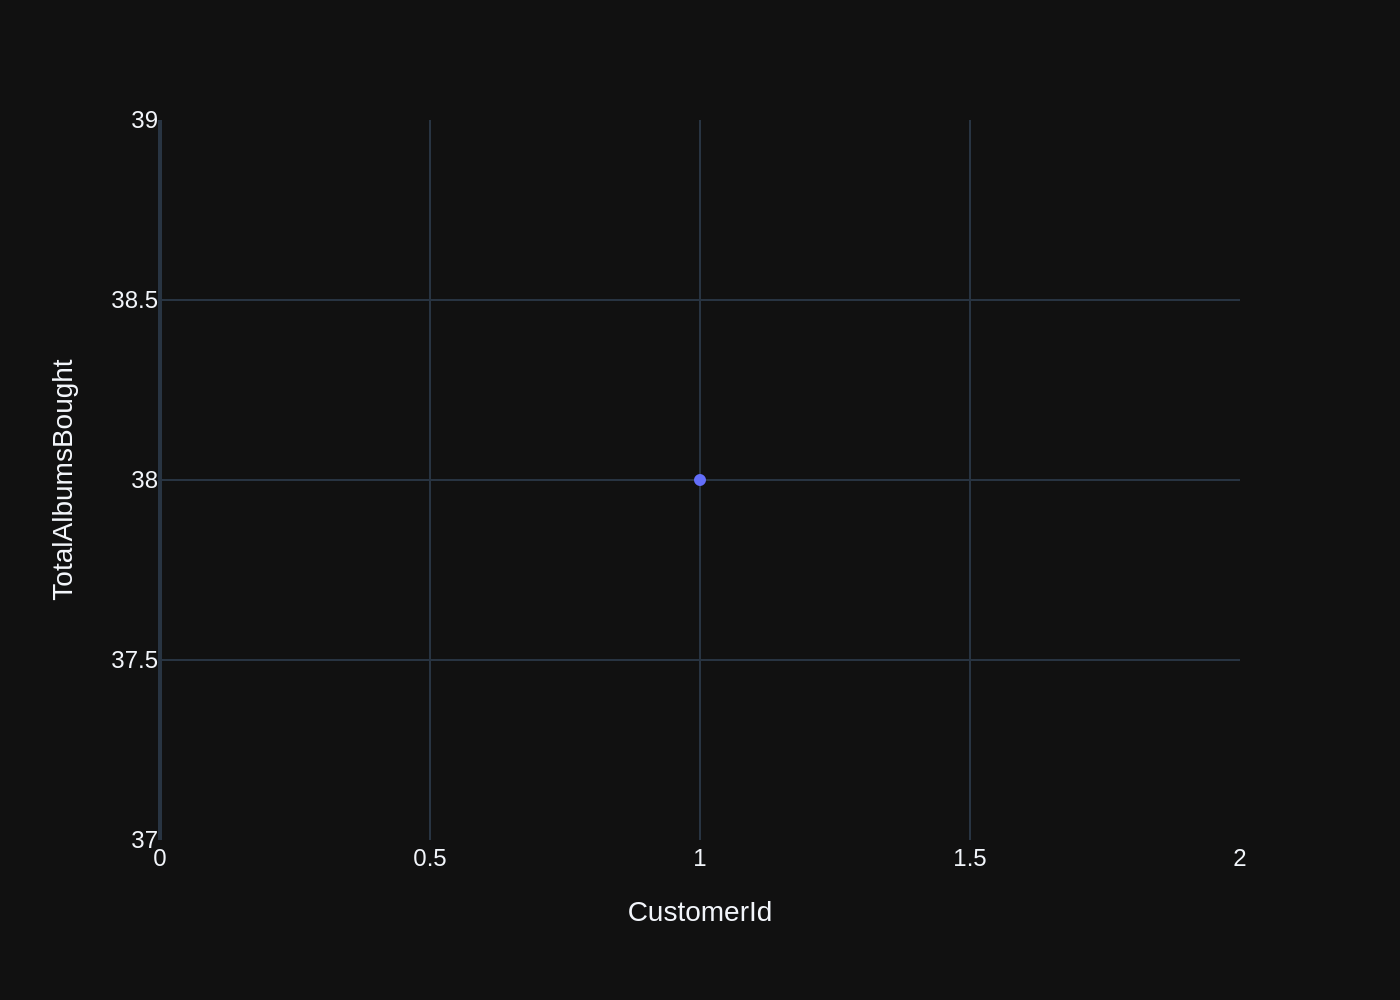





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


Using model gpt-3.5-turbo for 1424.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS TotalAlbumsBought
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
WHERE al.AlbumId IS NOT NULL
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalAlbumsBought DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS TotalAlbumsBought
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
WHERE al.AlbumId IS NOT NULL
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalAlbumsBought DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalAlbumsBought
0,1,Luís,Gonçalves,38
1,2,Leonie,Köhler,38
2,3,François,Tremblay,38
3,4,Bjørn,Hansen,38
4,5,František,Wichterlová,38


Using model gpt-3.5-turbo for 309.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.number(
        value=df['TotalAlbumsBought'][0],
        title="Total Albums Bought",
        format={"specifier": ",.0f"}
    )
else:
    fig = px.bar(df, x='FirstName', y='TotalAlbumsBought', title='Top 5 Customers by Total Albums Bought')
    fig.update_layout(xaxis_title='Customer Name', yaxis_title='Total Albums Bought')

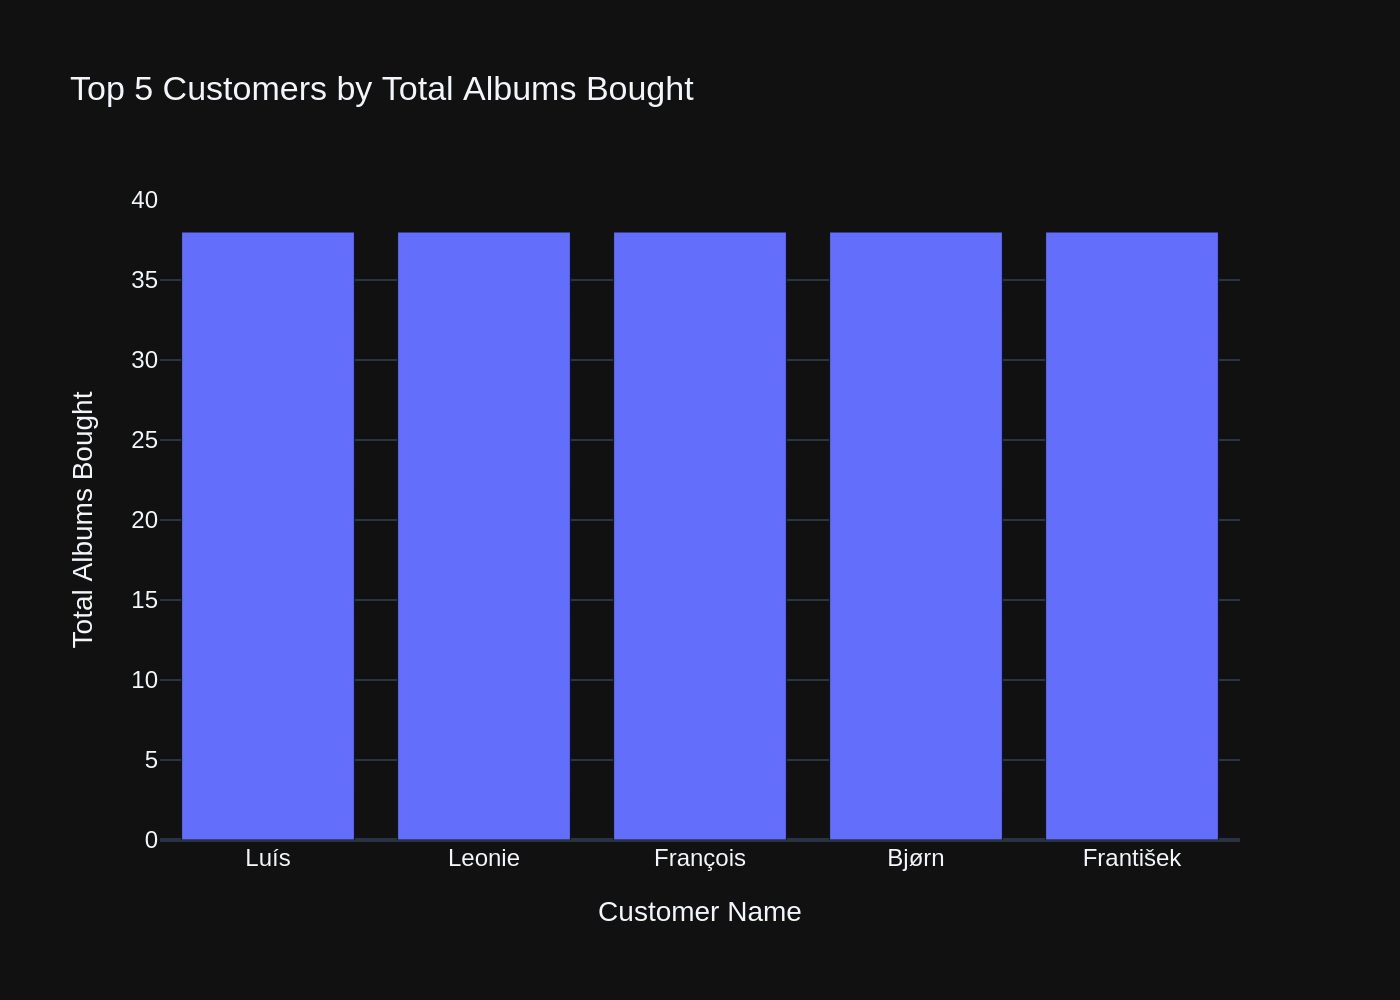





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


Using model gpt-3.5-turbo for 1808.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS TotalSpent
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalSpent DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS TotalSpent
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalSpent DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalSpent
0,6,Helena,Holý,49.62
1,26,Richard,Cunningham,47.62
2,57,Luis,Rojas,46.62
3,45,Ladislav,Kovács,45.62
4,46,Hugh,O'Reilly,45.62


Using model gpt-3.5-turbo for 265.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.indicator.Indicator(
        value=df['TotalSpent'][0],
        title="Total Spent"
    )
else:
    fig = px.bar(df, x='FirstName', y='TotalSpent', color='TotalSpent', title='Top 5 Customers by Total Spending')

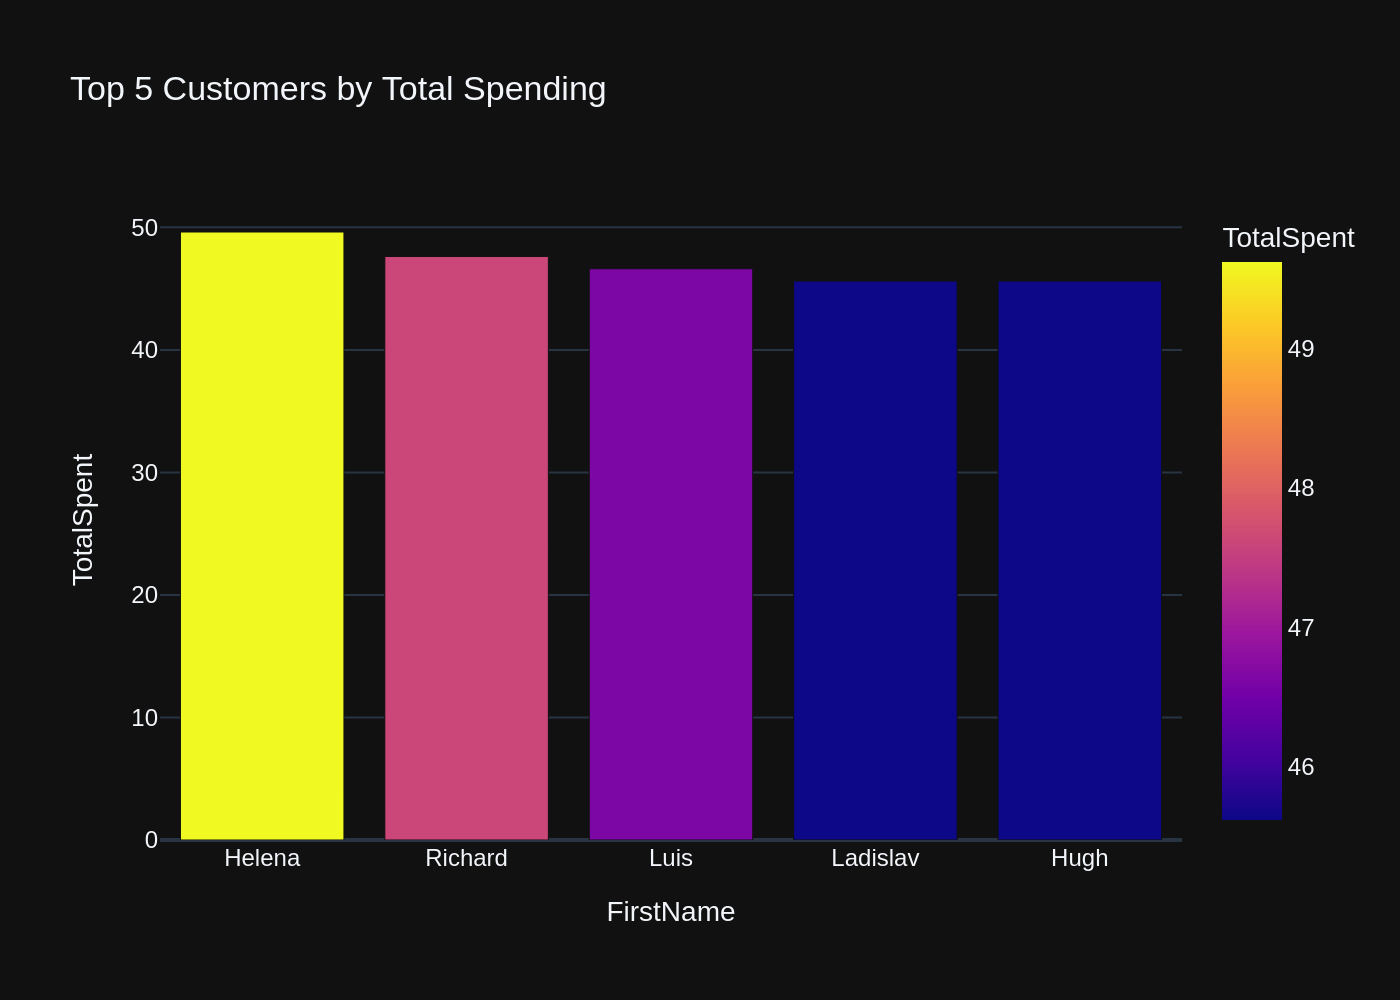





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


Using model gpt-3.5-turbo for 1392.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT p.Name AS PlaylistName, COUNT(pt.TrackId) AS TrackCount, SUM(t.Milliseconds) AS TotalDuration
FROM playlists p
JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY p.PlaylistId
HAVING TrackCount >= 10
LIMIT 20


[( <DataFrame> )]
queried dataframe



,PlaylistName,TrackCount,TotalDuration
0,Music,3290,877683083
1,TV Shows,213,501094957
2,90’s Music,1477,398705153
3,Music,3290,877683083
4,TV Shows,213,501094957
5,Brazilian Music,39,9486559
6,Classical,75,21770592
7,Classical 101 - Deep Cuts,25,6755730
8,Classical 101 - Next Steps,25,7575051
9,Classical 101 - The Basics,25,7439811


Using model gpt-3.5-turbo for 246.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.gauge(
        value=df['TotalDuration'][0],
        title='Total Duration',
        mode='gauge+number',
        domain={'x': [0, 1], 'y': [0, 1]}
    )
else:
    fig = px.bar(df, x='PlaylistName', y='TotalDuration', text='TotalDuration', title='Total Duration of Playlists with at least 10 Tracks')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

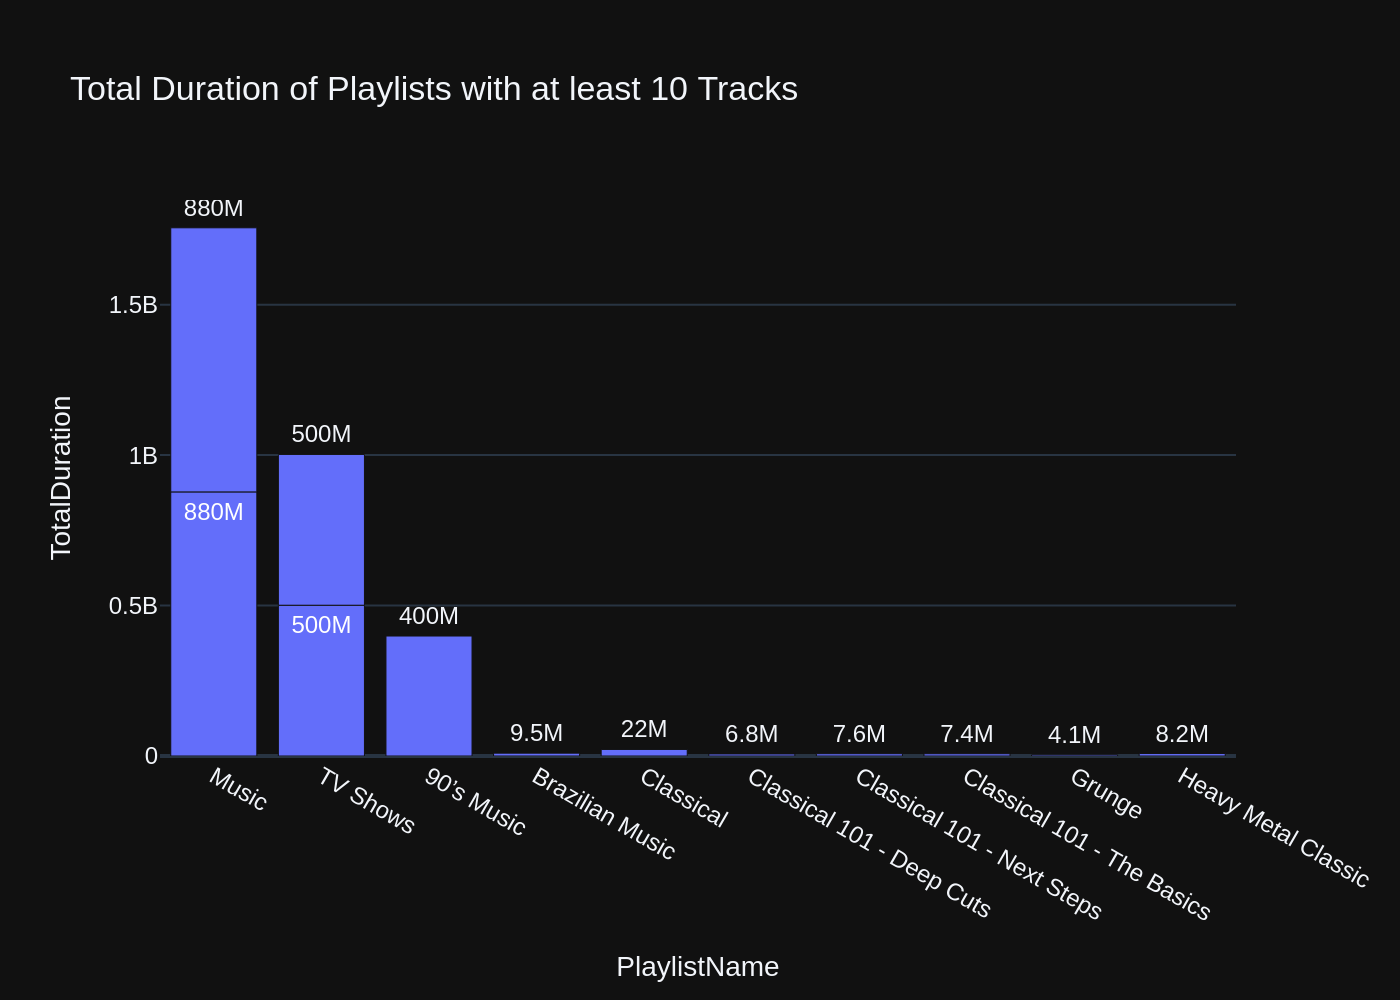





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:


Using model gpt-3.5-turbo for 1484.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT DISTINCT ar.Name AS ArtistName
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId, t.Name
HAVING COUNT(DISTINCT t.GenreId) > 1



[( <SQL> )]
generated SQL statement



SELECT DISTINCT ar.Name AS ArtistName
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId, t.Name
HAVING COUNT(DISTINCT t.GenreId) > 1


[( <DataFrame> )]
queried dataframe



,ArtistName
0,Antônio Carlos Jobim
1,Iron Maiden
2,Ozzy Osbourne
3,The Office


Using model gpt-3.5-turbo for 216.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicators.Indicator(
        mode="number",
        value=df['ArtistName'][0],
        title="Artist Name"
    )
else:
    fig = px.bar(df, x='ArtistName', title="Artists with Tracks in Multiple Genres")
    fig.update_layout(xaxis_title="Artist Name", yaxis_title="Count")

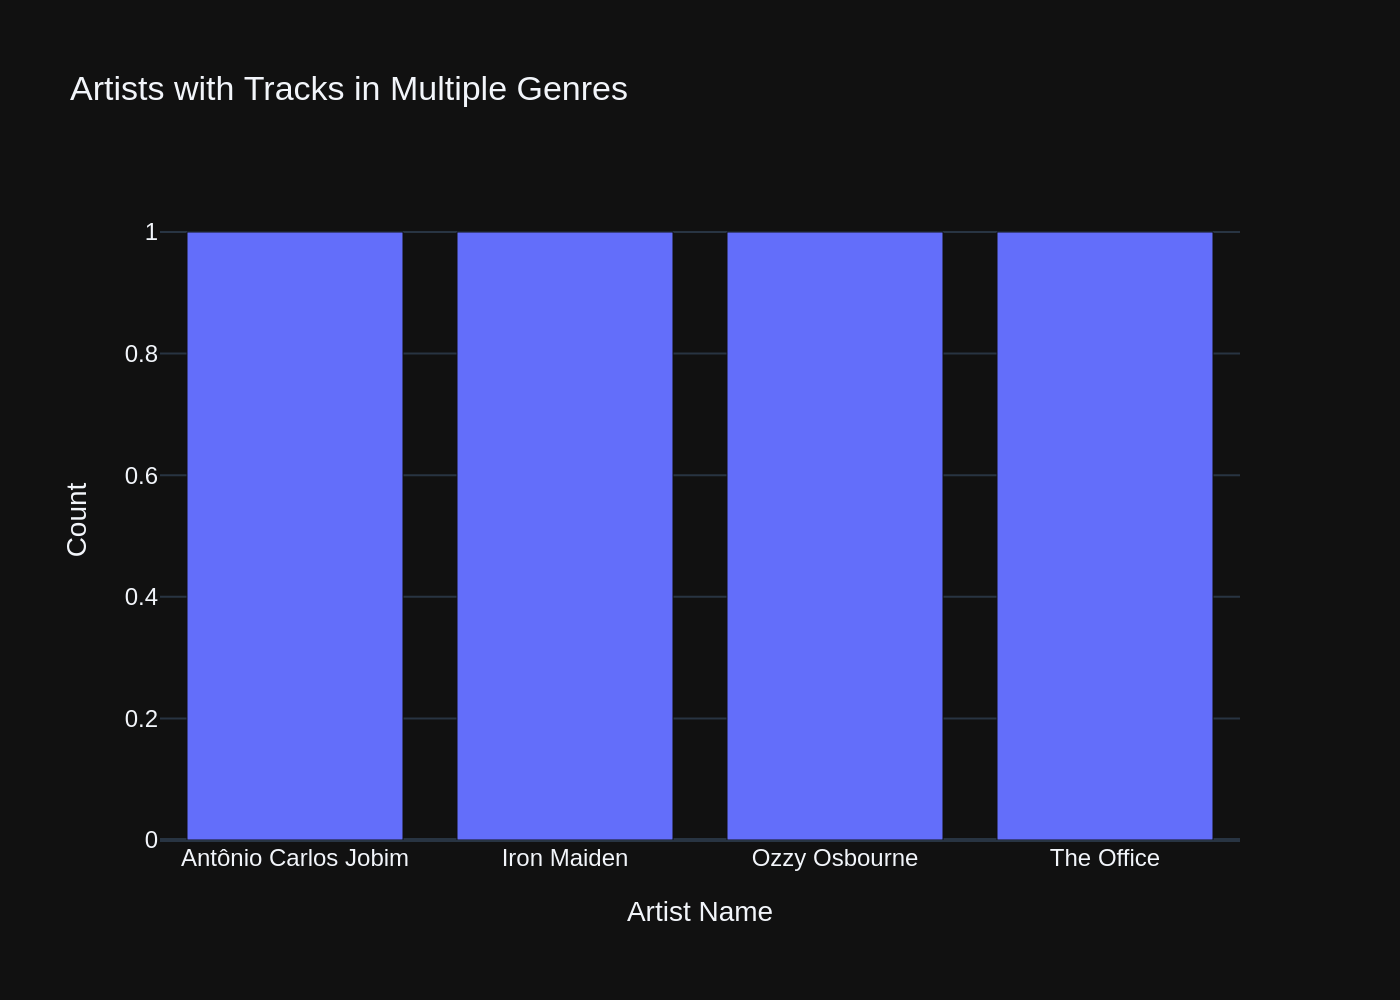

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'gpt-3.5-turbo' 
 took 74 sec
 run on 'ducklover1' 
 at 20241122-203041


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-gpt-3.5-turbo-74s-ducklover1-20241122-203041.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,1c37d83d-2aa9-503f-8caf-10b966d572ee-sql,\n Generating SQL for this ...,SELECT SUM(Total) AS TotalAmountInvoiced\nFROM...,sql
1,239fbea8-01dd-5090-a024-c57754a7330f-sql,How many customers are there,SELECT COUNT(CustomerId) AS TotalCustomers\nFR...,sql
2,359131a3-86c4-5ed9-8798-de203b4c00e0-sql,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
3,47dbe44d-6353-5d4e-a88b-ae6ad8ab0faa-sql,\n Can you find the top 10 most popula...,"SELECT ar.Name AS ArtistName, COUNT(t.TrackId)...",sql
4,4be9ad5e-72f7-55fe-9982-79524c3f1729-sql,Identify artists who have albums with tracks a...,SELECT DISTINCT ar.Name AS ArtistName\nFROM ar...,sql
5,4c945fb6-ccc4-5f9a-8b1b-021ec053489a-sql,what are the top 5 countries that customers co...,"SELECT Country, COUNT(CustomerId) AS CustomerC...",sql
6,60b5d98e-52a5-5383-b6cc-bc11886b2a70-sql,Get all playlists containing at least 10 track...,"SELECT p.Name AS PlaylistName, COUNT(pt.TrackI...",sql
7,74140ebf-9f30-5c2a-93ea-2869ae4d5508-sql,Find the customer who bought the most albums i...,"SELECT c.CustomerId, c.FirstName, c.LastName, ...",sql
8,770a143c-29be-58cc-ab78-cb5ee3d1d72f-sql,Find the total number of invoices per country,"SELECT c.Country, COUNT(i.InvoiceId) AS TotalI...",sql
9,7ac1fe1f-fbca-5253-a91a-779c089778db-sql,Get the average invoice total for each customer:,"SELECT CustomerId, AVG(Total) AS AvgInvoiceTot...",sql


In [22]:
df_training_data.to_csv(file_csv, index=False)